In [1]:
import sys
import torch 
import torch as th 
import torch.nn as nn
import os
from os.path import join
import json
from pprint import pprint
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
from stats_plot_utils import saveallforms, add_rectangles

In [2]:
def sweep_classifier_result(repr_dir, t_list=[0, 1, 10, 25, 50, 100, 250, 500, 1000], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=False):
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            for dimred_str in dimred_strs:
                ckpt_str = "RNDINIT" if epoch == -1 else \
                           f"{epoch:07d}{'EMA' if use_ema else ''}"
                try:
                    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl"), "rb"))
                except FileNotFoundError:
                    print(f"File not found: {repr_dir}/results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl")
                    continue
                test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
                train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
                syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
                syn_df.columns = ["Test Accuracy", "Train Accuracy"]
                syn_df["t"] = t_scalar
                syn_df["epoch"] = epoch
                syn_df["dimred"] = dimred_str
                # drop index as layer name
                syn_df = syn_df.reset_index()
                syn_df = syn_df.rename(columns={"index": "Layer"})
                syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    syn_df_all = syn_df_all.reset_index(drop=True)
    return syn_df_all

In [ ]:
!ls {exproot}/090*/repr_classifier

model_PCA_col_t0_0_avgtoken_ckpt0020000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0020000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0100000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0100000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0200000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0200000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0500000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0500000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0700000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0700000.pkl
model_PCA_col_t0_0_avgtoken_ckpt1000000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt1000000.pkl
model_PCA_col_t0_0_avgtoken_ckptRNDINIT.pkl
model_PCA_col_t0_0_pca1024_ckpt1000000.pkl
model_PCA_col_t0_0_pca128_ckpt1000000.pkl
model_PCA_col_t0_0_pca384_ckpt0020000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0020000.pkl
model_PCA_col_t0_0_pca384_ckpt0100000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0100000.pkl
model_PCA_col_t0_0_pca384_ckpt0200000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0200000.pkl
model_PCA_col_t0_0_pca384_ckpt0500000EMA.pkl
model_PCA_col_t0_0_

In [3]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"

In [4]:
!ls {exproot} | grep "^10[3-8]"
!ls {exproot} | grep "^11[0-8]"

103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel3_20241113-0056
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel5_20241113-0057
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057
110-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1600
111-RAVEN10_abstract-uncond-DiT_

In [19]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = "106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
syn_df_DiT = sweep_classifier_result(repr_dir, t_list=[0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 200.0, 1000.0], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=False)

figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)
expname_short = expname.split("/")[-1].split("_2024")[0]
syn_df_DiT.to_csv(join(repr_dir, "repr_classifier_synopsis.csv"), index=False)
syn_df_DiT.to_csv(join(figexpdir, "repr_classifier_synopsis.csv"), index=False)

File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/repr_classifier/results_col_t1_0_pca384_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/repr_classifier/results_col_t1_0_avgtoken_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/repr_classifier/results_col_t1_0_pca384_ckpt0020000.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/repr_classifier/results_col_t1_0_avgtoken_ckpt0020000.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Pr

In [26]:
print(syn_df_DiT.nlargest(5, "Test Accuracy"))  # [["Layer", "Test Accuracy", "Train Accuracy", "t", "epoch", "dimred"]]

Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
199  blocks.11       0.990800        0.999992  25.0   700000  avgtoken
189  blocks.11       0.989250        0.999967  25.0   500000  avgtoken
259  blocks.11       0.987925        0.999450  50.0   500000  avgtoken
269  blocks.11       0.986625        0.999358  50.0   700000  avgtoken
209  blocks.11       0.986400        0.999975  25.0  1000000  avgtoken

### Sweep through experiments

In [5]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
syndir = join(figroot, "synopsis")
os.makedirs(syndir, exist_ok=True)

In [6]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expnames = [
    "103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052",
    "104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052",
    "104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052", 
    "105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052",
    "106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052",
    "106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052",
    "107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056",
    "107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056",
    "107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056",
    "107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel3_20241113-0056",
    "108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel5_20241113-0057",
    "108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057",
    "114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel012_20241116-0330",
    "114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel01234_20241116-0330",
    "114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel56_20241116-0330",
    "115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel014_20241116-0330",
    "116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel1234_20241116-0331",
    "117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0123456_20241116-0331",
    "117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel023_20241116-0331",
    "117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel034_20241116-0331",
    "117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel123_20241116-0331",
    "117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel789_20241116-0331",
    "118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel234_20241116-0331"
]
syn_df_DiT_col = {}
for expname in expnames:
    expdir = join(exproot, expname)
    ckptdir = join(expdir, "checkpoints")
    repr_dir = join(expdir, "repr_classifier")
    syn_df_DiT = sweep_classifier_result(repr_dir, t_list=[0.0, 10.0, 25.0, 50.0, 100.0, 200.0, 500.0, 1000.0],  # 1.0, 250.0, 
                                epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                                dimred_strs=["pca384", "avgtoken"], use_ema=False)
    figexpdir = join(figroot, expname)
    os.makedirs(figexpdir, exist_ok=True)
    expname_short = expname.split("/")[-1].split("_2024")[0]
    syn_df_DiT.to_csv(join(repr_dir, "repr_classifier_synopsis.csv"), index=False)
    syn_df_DiT.to_csv(join(figexpdir, "repr_classifier_synopsis.csv"), index=False)
    print(expname)
    print(syn_df_DiT.nlargest(5, "Test Accuracy"))
    # add a column for expname
    syn_df_DiT["expname"] = expname
    syn_df_DiT_col[expname] = syn_df_DiT 

syn_df_DiT_cat = pd.concat(syn_df_DiT_col.values(), axis=0)
syn_df_DiT_cat
syn_df_DiT_cat.to_csv(join(syndir, "repr_classifier_synopsis_increasing_heldout.csv"), index=False)

File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052/repr_classifier/results_col_t200_0_pca384_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052/repr_classifier/results_col_t200_0_avgtoken_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052/repr_classifier/results_col_t500_0_pca384_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052/repr_classifier/results_col_t500_0_avgtoken_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users

In [7]:
syn_df_DiT_cat.to_csv(join(syndir, "repr_classifier_synopsis_increasing_heldout.csv"), index=False)

### Synopsis across the 12 runs

In [7]:
syn_df_DiT_cat = pd.read_csv(join(syndir, "repr_classifier_synopsis_increasing_heldout.csv"))

In [8]:
# find the 5 largest Test Accuracy for each expname
syn_df_DiT_cat.groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


/tmp/ipykernel_3091473/4236398127.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  syn_df_DiT_cat.groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


Layer  \
expname                                                             
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 269  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   

                                                        Test Accuracy  \
expname                                                                 
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.976150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.991150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997125   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996575   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.985675   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.990800   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.978750   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 269       0.993700   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996350   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997600   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.995800   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.994100   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.993325   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996975   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.992300   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997900   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.996775   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.963075   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.996325   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997000   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.954275   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.995825   

                                                        Train Accuracy     t  \
expname                                                                        
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189        0.993642  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.999708  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
106-RAVEN10_abstract-uncond-

In [9]:
# find the 5 largest Test Accuracy for each expname, limit to 1000000 epoch
syn_df_DiT_cat.query("epoch == 1000000").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))

/tmp/ipykernel_3091473/901570136.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  syn_df_DiT_cat.query("epoch == 1000000").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


Layer  \
expname                                                             
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 138   blocks.8   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 208   blocks.8   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 119  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 178   blocks.8   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   

                                                        Test Accuracy  \
expname                                                                 
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 138       0.935900   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.991150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997125   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996575   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.975700   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.986400   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.977850   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 208       0.993225   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996350   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997600   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.995525   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.994100   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.991175   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996975   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.992300   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997900   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996625   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 119       0.914300   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997000   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 178       0.950400   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.995825   

                                                        Train Accuracy     t  \
expname                                                                        
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 138        0.970458  10.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.999708  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
106-RAVEN10_abstract-uncond-

In [10]:
# find the 5 largest Test Accuracy for each expname, limit to 25.0 t and blocks.11 layer
syn_df_DiT_cat.query("dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))

/tmp/ipykernel_3091473/2748599259.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  syn_df_DiT_cat.query("dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


Layer  \
expname                                                             
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 149  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   

                                                        Test Accuracy  \
expname                                                                 
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.976150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.991150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997125   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996575   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.985675   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.990800   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.978750   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.991650   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996350   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997600   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.995800   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.994100   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.993325   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996975   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.992300   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997900   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.996775   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 149       0.956325   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.996325   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997000   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.954275   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.995825   

                                                        Train Accuracy     t  \
expname                                                                        
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189        0.993642  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.999708  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
106-RAVEN10_abstract-uncond-

In [11]:
# find the 5 largest Test Accuracy for each expname, limit to 1000000 epoch
syn_df_DiT_cat.query("epoch == 1000000 and dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))

/tmp/ipykernel_3091473/3698773243.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  syn_df_DiT_cat.query("epoch == 1000000 and dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


Layer  \
expname                                                             
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   

                                                        Test Accuracy  \
expname                                                                 
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.880300   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.991150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997125   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996575   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.975700   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.986400   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.977850   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.990650   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996350   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997600   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.995525   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.994100   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.991175   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996975   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.992300   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997900   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996625   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.766075   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997000   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.950100   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.995825   

                                                        Train Accuracy     t  \
expname                                                                        
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.922150  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.999708  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
106-RAVEN10_abstract-uncond-

### Rule Hold out information

In [14]:
# try to load the args.json for each expname
heldout_profiles = {}
for expname in expnames:
    expdir = join(exproot, expname)
    args_path = join(expdir, "args.json")
    if os.path.exists(args_path):
        args = json.load(open(args_path, "r"))
        heldout_ids = args["heldout_ids"]
        heldout_profiles[expname] = heldout_ids
    else:
        print(f"Args file not found for {expname}")

In [15]:
for expname, heldout_ids in heldout_profiles.items():
    print(expname, '\t heldout #', len(set(heldout_ids)), set(heldout_ids))

103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052 	 heldout # 27 {0, 1, 3, 4, 5, 8, 10, 12, 14, 16, 17, 19, 20, 21, 24, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39}
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052 	 heldout # 10 {1, 34, 36, 37, 39, 8, 12, 16, 20, 24}
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052 	 heldout # 15 {1, 34, 33, 36, 37, 5, 39, 8, 38, 12, 16, 17, 20, 21, 24}
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052 	 heldout # 5 {1, 34, 37, 16, 20}
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052 	 heldout # 19 {1, 3, 5, 8, 10, 12, 16, 17, 20, 21, 24, 29, 31, 33, 34, 36, 37, 38, 39}
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052 	 heldout # 23 {0, 1, 3, 5, 8, 10, 12, 14, 16, 17, 20, 21, 24, 27, 29, 31, 33, 34, 35, 36, 37, 38, 39}
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056 	 heldout # 1

### Summary or Synopsis across runs

In [25]:
# find the 5 largest Test Accuracy for each expname, limit to 1000000 epoch
summary_df = syn_df_DiT_cat.groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"), include_groups=True)
# add a column for heldout #
summary_df["heldout_num"] = summary_df["expname"].apply(lambda x: len(set(heldout_profiles[x])))
# add a column for heldout_rules
summary_df["heldout_rules"] = summary_df["expname"].apply(lambda x: sorted(set(heldout_profiles[x])))
summary_df.to_csv(join(syndir, "repr_classifier_increasing_heldout_synopsis_ANY.csv"), index=False)
summary_df


/tmp/ipykernel_3091473/2771746116.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = syn_df_DiT_cat.groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"), include_groups=True)


Layer  \
expname                                                             
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 269  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   

                                                        Test Accuracy  \
expname                                                                 
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.976150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.991150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997125   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996575   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.985675   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.990800   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.978750   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 269       0.993700   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996350   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997600   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.995800   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.994100   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.993325   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996975   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.992300   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997900   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.996775   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.963075   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.996325   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997000   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.954275   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.995825   

                                                        Train Accuracy     t  \
expname                                                                        
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189        0.993642  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.999708  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
106-RAVEN10_abstract-uncond-

In [23]:
# find the 5 largest Test Accuracy for each expname, limit to 1000000 epoch
summary_df = syn_df_DiT_cat.query("dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"), include_groups=True)
# add a column for heldout #
summary_df["heldout_num"] = summary_df["expname"].apply(lambda x: len(set(heldout_profiles[x])))
# add a column for heldout_rules
summary_df["heldout_rules"] = summary_df["expname"].apply(lambda x: sorted(set(heldout_profiles[x])))
summary_df.to_csv(join(syndir, "repr_classifier_increasing_heldout_synopsis_finallayer_avgtoken_t25_epANY.csv"), index=False)
summary_df


/tmp/ipykernel_3091473/1066118276.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = syn_df_DiT_cat.query("dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"), include_groups=True)


Layer  \
expname                                                             
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 149  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169  blocks.11   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   

                                                        Test Accuracy  \
expname                                                                 
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.976150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.991150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997125   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996575   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.985675   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.990800   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.978750   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.991650   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996350   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997600   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.995800   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.994100   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.993325   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996975   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.992300   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997900   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.996775   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 149       0.956325   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 199       0.996325   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997000   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 169       0.954275   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.995825   

                                                        Train Accuracy     t  \
expname                                                                        
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189        0.993642  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.999708  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
106-RAVEN10_abstract-uncond-

In [24]:
# find the 5 largest Test Accuracy for each expname, limit to 1000000 epoch
summary_df = syn_df_DiT_cat.query("dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11' and epoch == 1000000").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"), include_groups=True)
# add a column for heldout #
summary_df["heldout_num"] = summary_df["expname"].apply(lambda x: len(set(heldout_profiles[x])))
# add a column for heldout_rules
summary_df["heldout_rules"] = summary_df["expname"].apply(lambda x: sorted(set(heldout_profiles[x])))
summary_df.to_csv(join(syndir, "repr_classifier_increasing_heldout_synopsis_finallayer_avgtoken_t25_ep1000000.csv"), index=False)
summary_df


/tmp/ipykernel_3091473/1633152964.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = syn_df_DiT_cat.query("dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11' and epoch == 1000000").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"), include_groups=True)


Layer  \
expname                                                             
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179  blocks.11   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189  blocks.11   

                                                        Test Accuracy  \
expname                                                                 
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.880300   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.991150   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997125   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996575   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.975700   
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.986400   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.977850   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.990650   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996350   
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997600   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.995525   
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.994100   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.991175   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996975   
114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.992300   
115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997900   
116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.996625   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.766075   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.996125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209       0.997000   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.997125   
117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 179       0.950100   
118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 189       0.995825   

                                                        Train Accuracy     t  \
expname                                                                        
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.922150  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        0.999708  25.0   
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M... 209        1.000000  25.0   
106-RAVEN10_abstract-uncond-

### Export tables

In [26]:
summary_df = pd.read_csv(join(syndir, "repr_classifier_increasing_heldout_synopsis_finallayer_avgtoken_t25_ep1000000.csv"))

In [27]:
summary_df

Layer  Test Accuracy  Train Accuracy     t    epoch    dimred  \
0   blocks.11       0.880300        0.922150  25.0  1000000  avgtoken   
1   blocks.11       0.991150        0.999708  25.0  1000000  avgtoken   
2   blocks.11       0.997125        1.000000  25.0  1000000  avgtoken   
3   blocks.11       0.996575        1.000000  25.0  1000000  avgtoken   
4   blocks.11       0.975700        0.995492  25.0  1000000  avgtoken   
5   blocks.11       0.986400        0.999975  25.0  1000000  avgtoken   
6   blocks.11       0.977850        0.987575  25.0  1000000  avgtoken   
7   blocks.11       0.990650        0.999483  25.0  1000000  avgtoken   
8   blocks.11       0.996350        1.000000  25.0  1000000  avgtoken   
9   blocks.11       0.997600        1.000000  25.0  1000000  avgtoken   
10  blocks.11       0.995525        0.999992  25.0  1000000  avgtoken   
11  blocks.11       0.994100        0.999317  25.0  1000000  avgtoken   
12  blocks.11       0.991175        1.000000  25.0  1000000  avgtoken   
13  blocks.11       0.996975        1.000000  25.0  1000000  avgtoken   
14  blocks.11       0.992300        0.999983  25.0  1000000  avgtoken   
15  blocks.11       0.997900        1.000000  25.0  1000000  avgtoken   
16  blocks.11       0.996625        1.000000  25.0  1000000  avgtoken   
17  blocks.11       0.766075        0.807708  25.0  1000000  avgtoken   
18  blocks.11       0.996125        1.000000  25.0  1000000  avgtoken   
19  blocks.11       0.997000        1.000000  25.0  1000000  avgtoken   
20  blocks.11       0.997125        1.000000  25.0  1000000  avgtoken   
21  blocks.11       0.950100        0.968275  25.0  1000000  avgtoken   
22  blocks.11       0.995825        1.000000  25.0  1000000  avgtoken   

                                              expname  heldout_num  \
0   103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           27   
1   104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           15   
2   104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           10   
3   105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            5   
4   106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           23   
5   106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           19   
6   107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           10   
7   107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           10   
8   107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            4   
9   107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            4   
10  108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            4   
11  108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            4   
12  114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           20   
13  114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
14  114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            8   
15  115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
16  116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           16   
17  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           28   
18  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
19  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
20  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
21  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
22  118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   

                                        heldout_rules  
0   [0, 1, 3, 4, 5, 8, 10, 12, 14, 16, 17, 19, 20,...  
1   [1, 5, 8, 12, 16, 17, 20, 21, 24, 33, 34, 36, ...  
2              [1, 8, 12, 16, 20, 24, 34, 36, 37, 39]  
3                                 [1, 16, 20, 34, 37]  
4   [0, 1, 3, 5, 8, 10, 12, 14, 16, 17, 20, 21, 24...  
5   [1, 3, 5, 8, 10, 12, 16, 17, 20, 21, 24, 29, 3...  
6                      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  
7            [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]  
8                                     [0, 10, 20, 30]  
9             

In [30]:
syndir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe/synopsis'

In [29]:
summary_df = pd.read_csv(join(syndir, "repr_classifier_increasing_heldout_synopsis_ANY.csv"))
summary_df

Layer  Test Accuracy  Train Accuracy     t    epoch    dimred  \
0   blocks.11       0.976150        0.993642  25.0   500000  avgtoken   
1   blocks.11       0.991150        0.999708  25.0  1000000  avgtoken   
2   blocks.11       0.997125        1.000000  25.0  1000000  avgtoken   
3   blocks.11       0.996575        1.000000  25.0  1000000  avgtoken   
4   blocks.11       0.985675        0.998225  25.0   500000  avgtoken   
5   blocks.11       0.990800        0.999992  25.0   700000  avgtoken   
6   blocks.11       0.978750        0.987108  25.0   700000  avgtoken   
7   blocks.11       0.993700        0.999950  50.0   700000  avgtoken   
8   blocks.11       0.996350        1.000000  25.0  1000000  avgtoken   
9   blocks.11       0.997600        1.000000  25.0  1000000  avgtoken   
10  blocks.11       0.995800        0.999992  25.0   700000  avgtoken   
11  blocks.11       0.994100        0.999317  25.0  1000000  avgtoken   
12  blocks.11       0.993325        1.000000  25.0   700000  avgtoken   
13  blocks.11       0.996975        1.000000  25.0  1000000  avgtoken   
14  blocks.11       0.992300        0.999983  25.0  1000000  avgtoken   
15  blocks.11       0.997900        1.000000  25.0  1000000  avgtoken   
16  blocks.11       0.996775        1.000000  25.0   700000  avgtoken   
17  blocks.11       0.963075        0.991458  50.0   200000  avgtoken   
18  blocks.11       0.996325        1.000000  25.0   700000  avgtoken   
19  blocks.11       0.997000        1.000000  25.0  1000000  avgtoken   
20  blocks.11       0.997125        1.000000  25.0  1000000  avgtoken   
21  blocks.11       0.954275        0.969575  25.0   700000  avgtoken   
22  blocks.11       0.995825        1.000000  25.0  1000000  avgtoken   

                                              expname  heldout_num  \
0   103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           27   
1   104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           15   
2   104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           10   
3   105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            5   
4   106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           23   
5   106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           19   
6   107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           10   
7   107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           10   
8   107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            4   
9   107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            4   
10  108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            4   
11  108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            4   
12  114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           20   
13  114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
14  114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...            8   
15  115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
16  116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           16   
17  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           28   
18  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
19  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
20  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
21  117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   
22  118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...           12   

                                        heldout_rules  
0   [0, 1, 3, 4, 5, 8, 10, 12, 14, 16, 17, 19, 20,...  
1   [1, 5, 8, 12, 16, 17, 20, 21, 24, 33, 34, 36, ...  
2              [1, 8, 12, 16, 20, 24, 34, 36, 37, 39]  
3                                 [1, 16, 20, 34, 37]  
4   [0, 1, 3, 5, 8, 10, 12, 14, 16, 17, 20, 21, 24...  
5   [1, 3, 5, 8, 10, 12, 16, 17, 20, 21, 24, 29, 3...  
6                      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  
7            [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]  
8                                     [0, 10, 20, 30]  
9             

### Individual run inspection

In [16]:
import json
from sklearn.metrics import confusion_matrix
from stats_plot_utils import add_rectangles, plot_rule_heatmap

In [17]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([120000, 3, 9, 9]) torch.Size([120000]) torch.Size([40000, 3, 9, 9]) torch.Size([40000])


103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.8803         0.92215  25.0  1000000  avgtoken


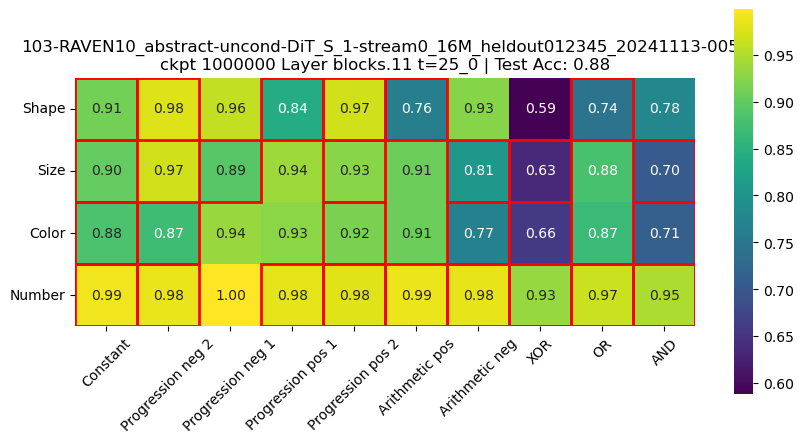

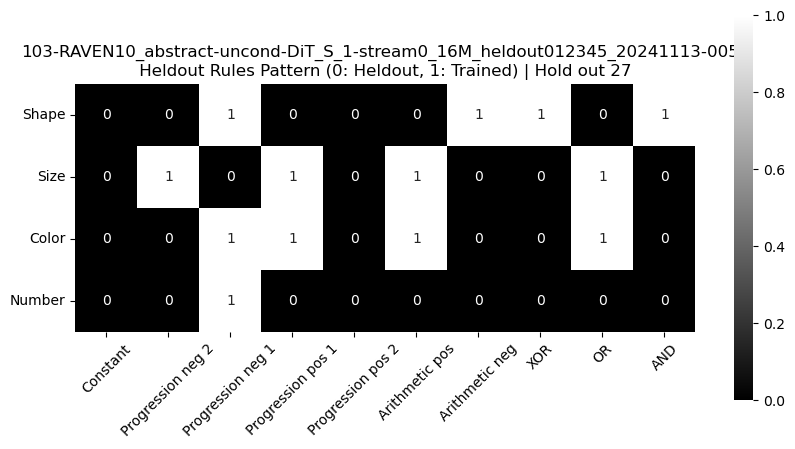

103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052 t-stat: -0.42, p-val: 6.74e-01


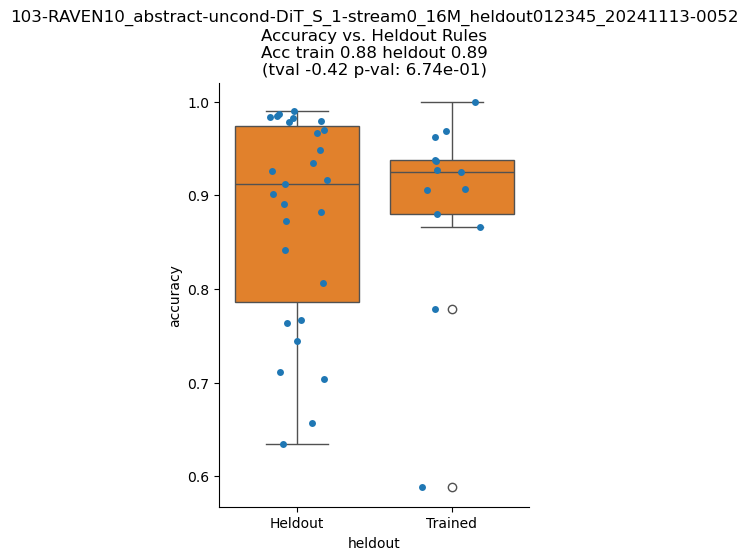

104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11       0.997125             1.0  25.0  1000000  avgtoken


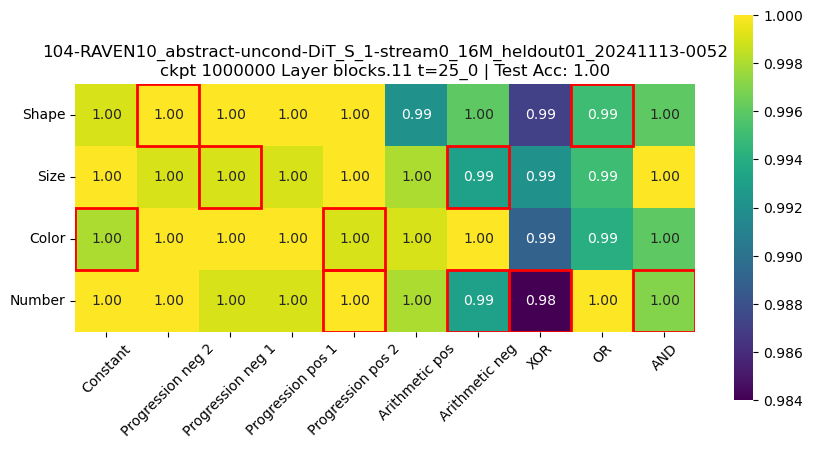

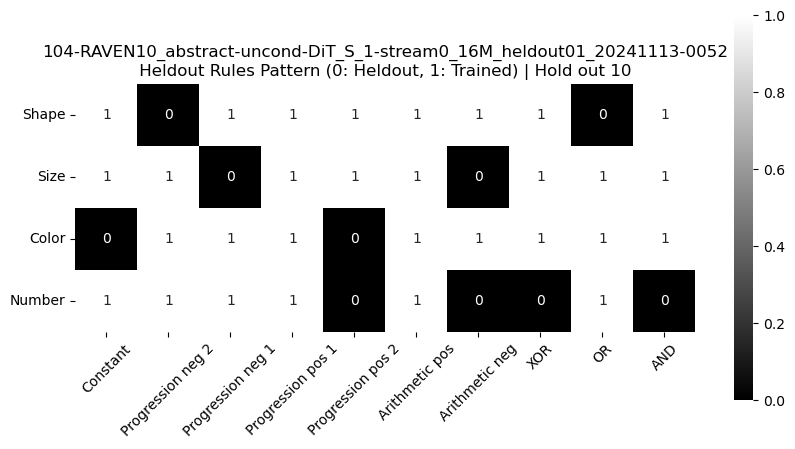

104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052 t-stat: -1.24, p-val: 2.24e-01


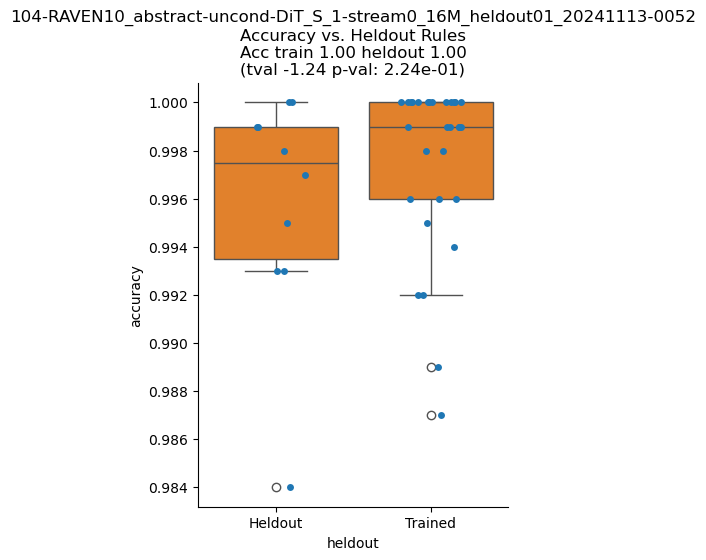

104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11        0.99115        0.999708  25.0  1000000  avgtoken


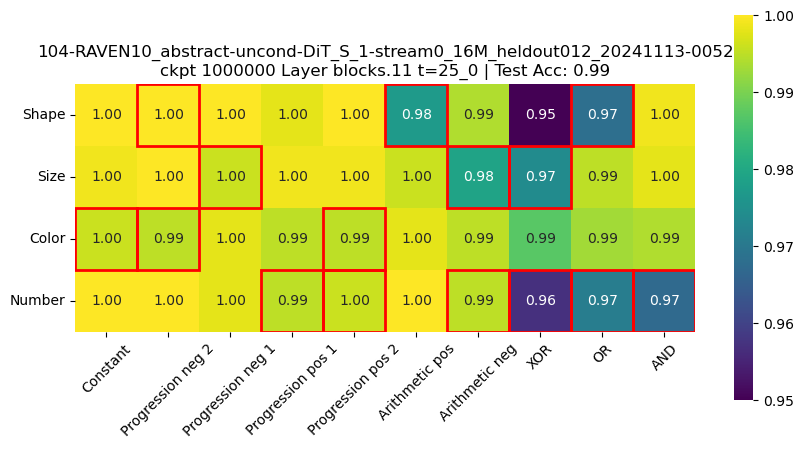

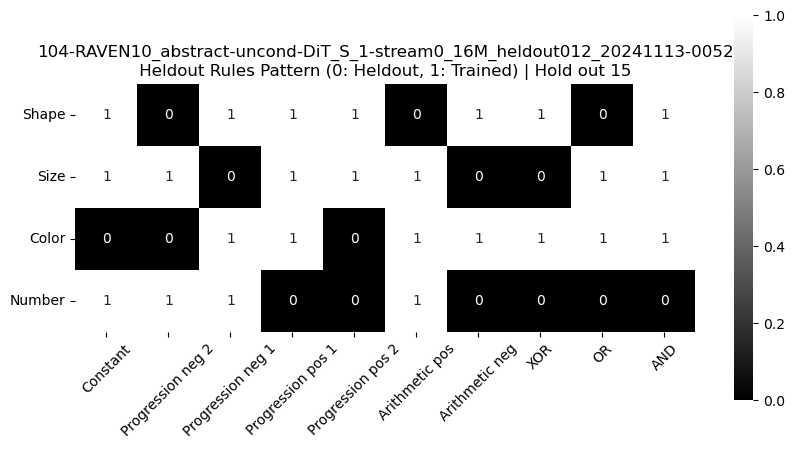

104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052 t-stat: -2.98, p-val: 5.05e-03


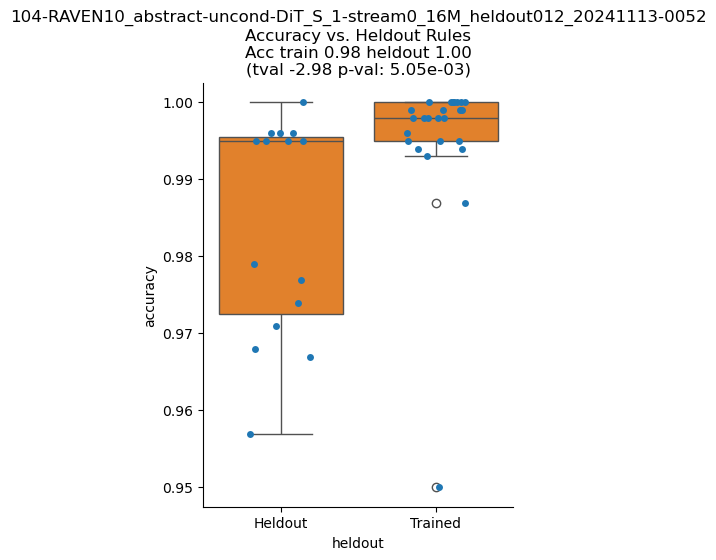

105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11       0.996575             1.0  25.0  1000000  avgtoken


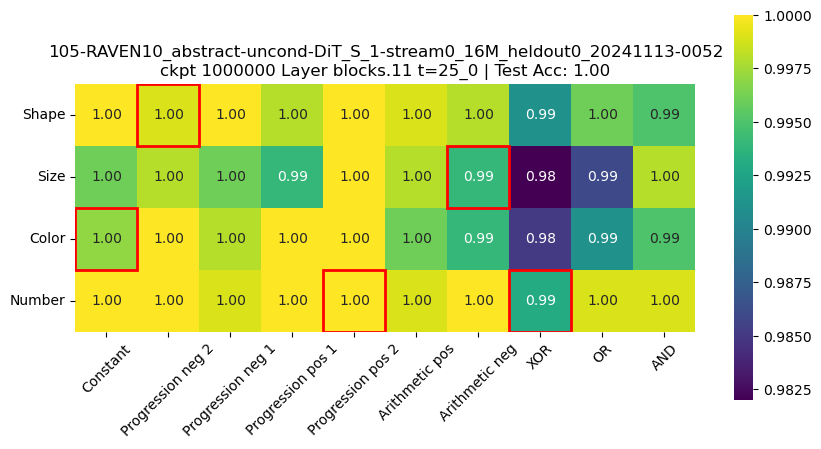

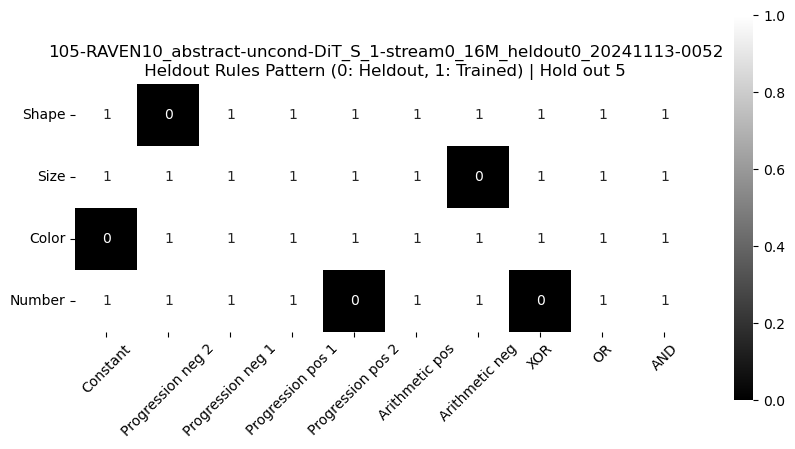

105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052 t-stat: 0.01, p-val: 9.89e-01


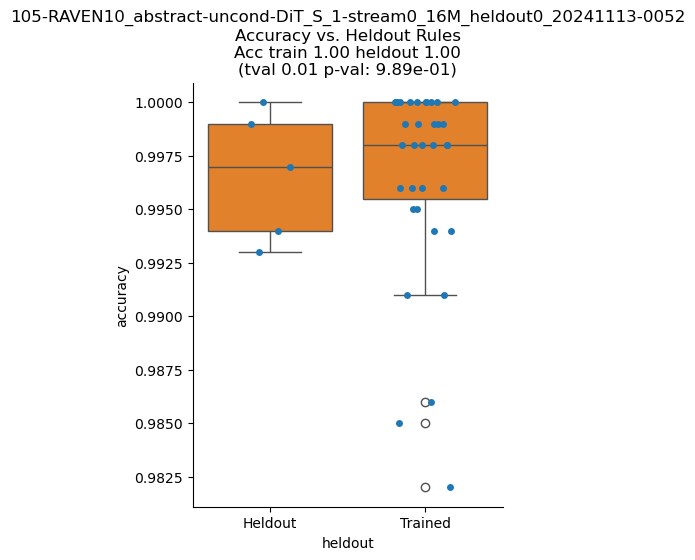

106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9864        0.999975  25.0  1000000  avgtoken


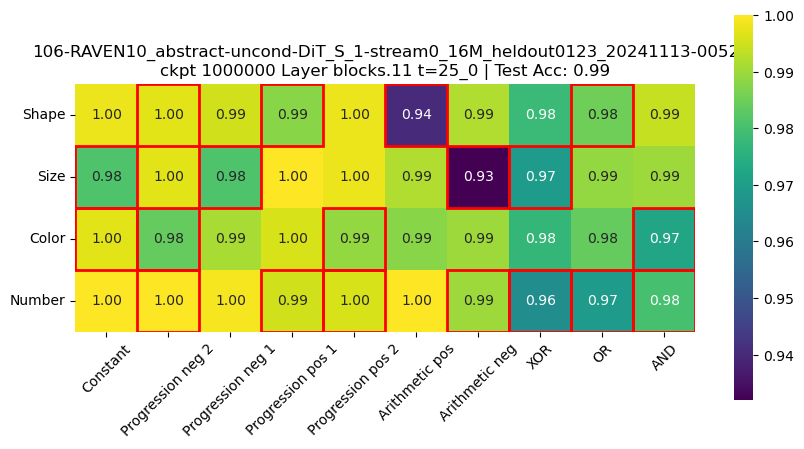

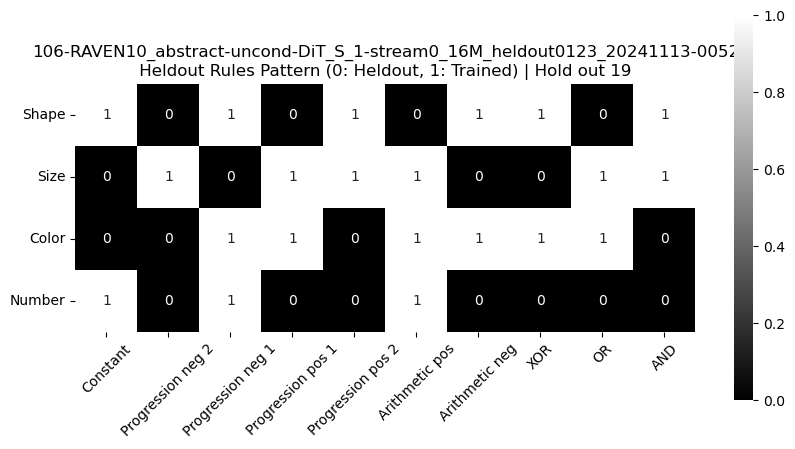

106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052 t-stat: -3.05, p-val: 4.15e-03


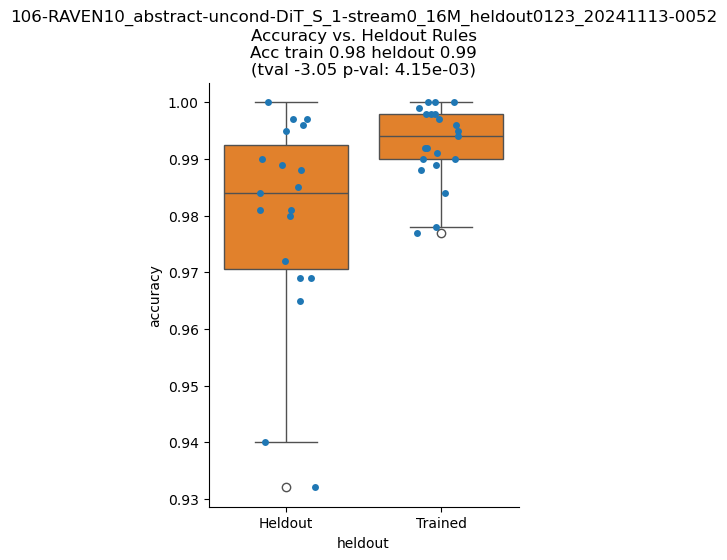

106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9757        0.995492  25.0  1000000  avgtoken


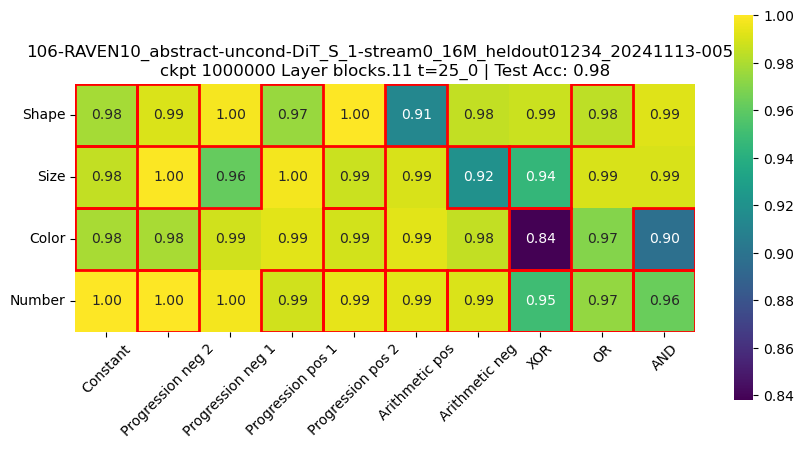

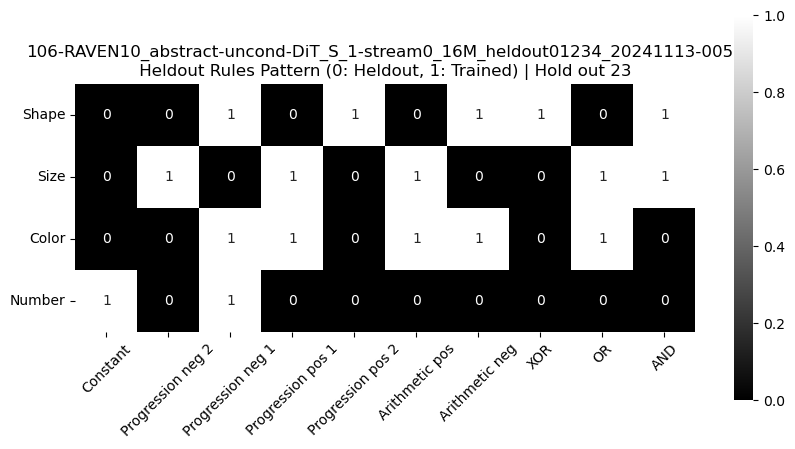

106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052 t-stat: -2.84, p-val: 7.20e-03


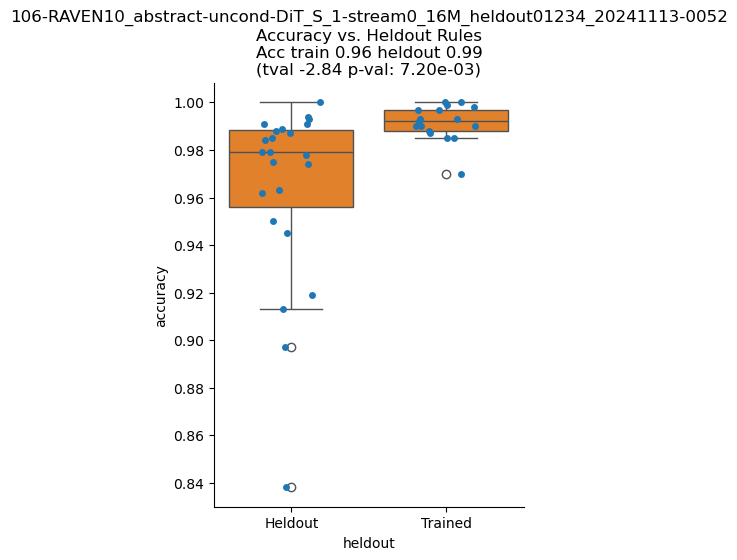

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11        0.97785        0.987575  25.0  1000000  avgtoken


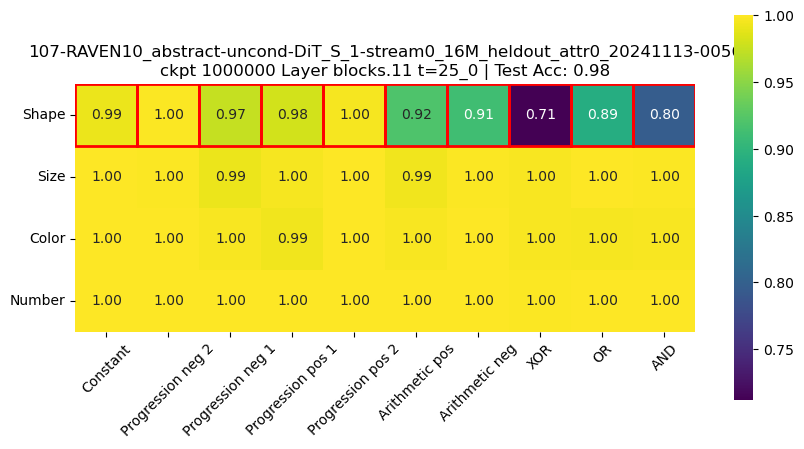

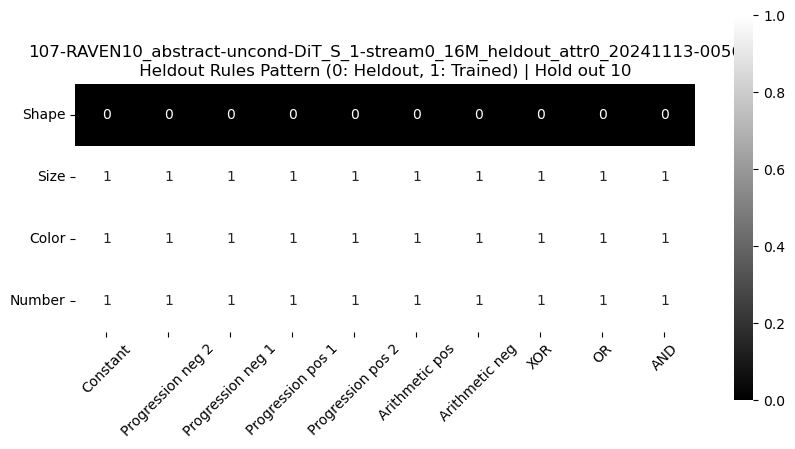

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056 t-stat: -4.75, p-val: 2.93e-05


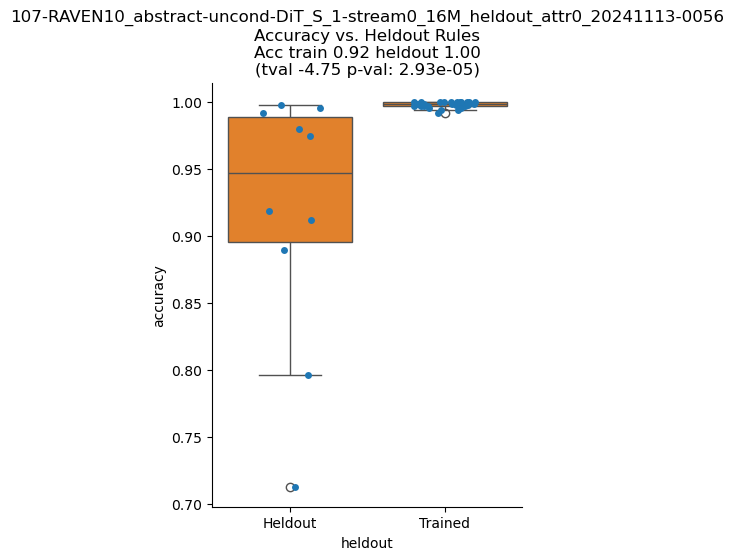

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11        0.99065        0.999483  25.0  1000000  avgtoken


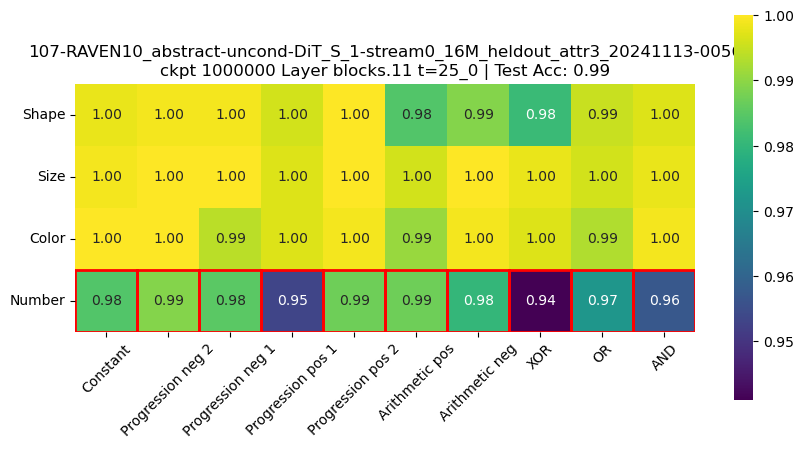

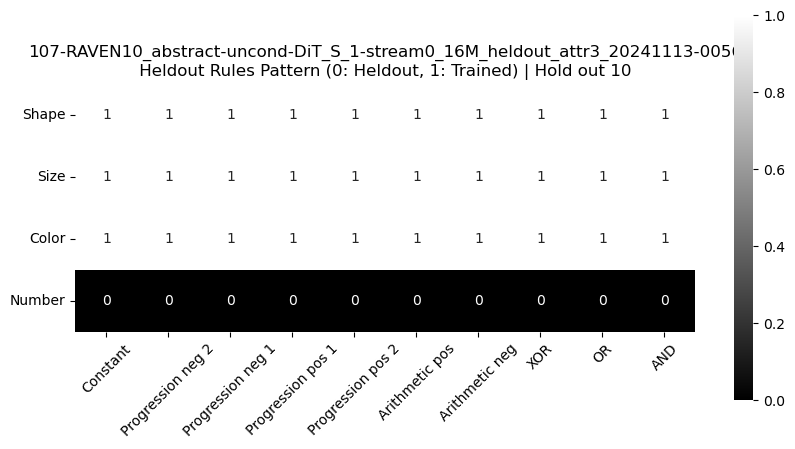

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056 t-stat: -6.75, p-val: 5.45e-08


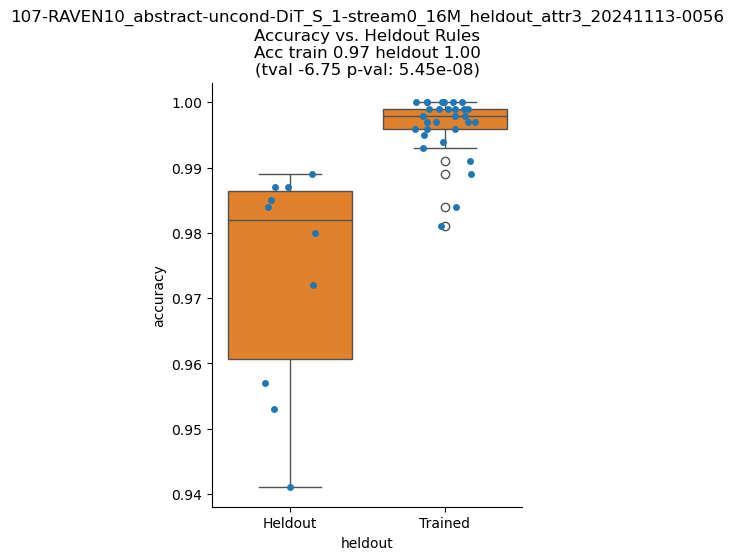

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11        0.99635             1.0  25.0  1000000  avgtoken


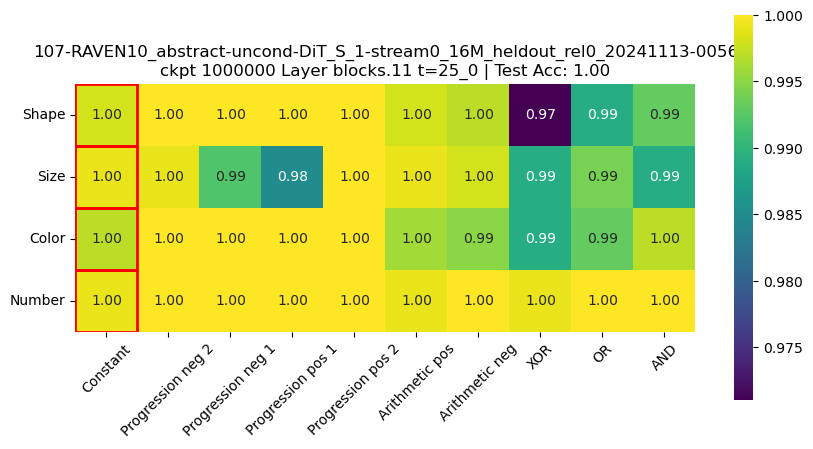

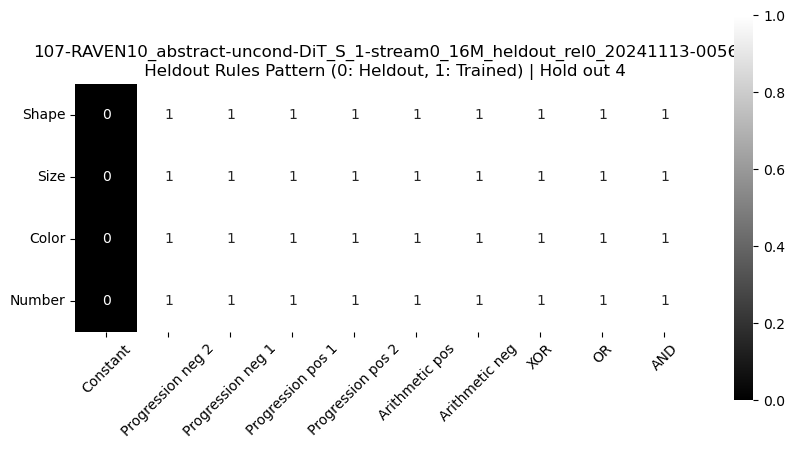

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056 t-stat: 0.69, p-val: 4.95e-01


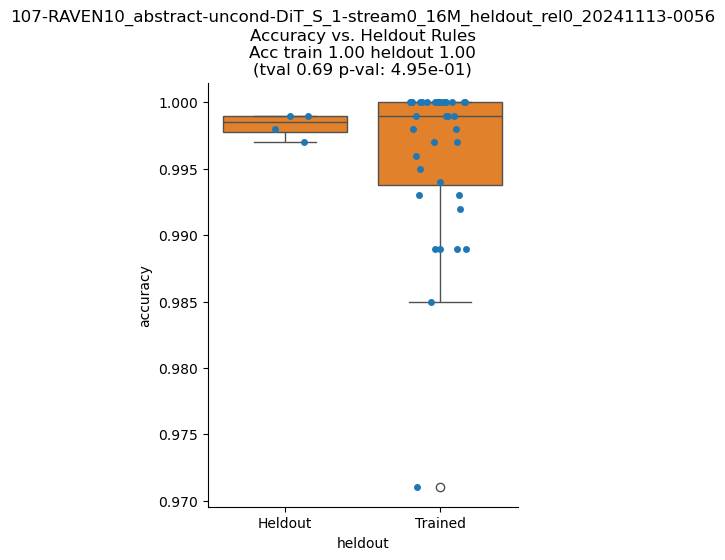

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel3_20241113-0056          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9976             1.0  25.0  1000000  avgtoken


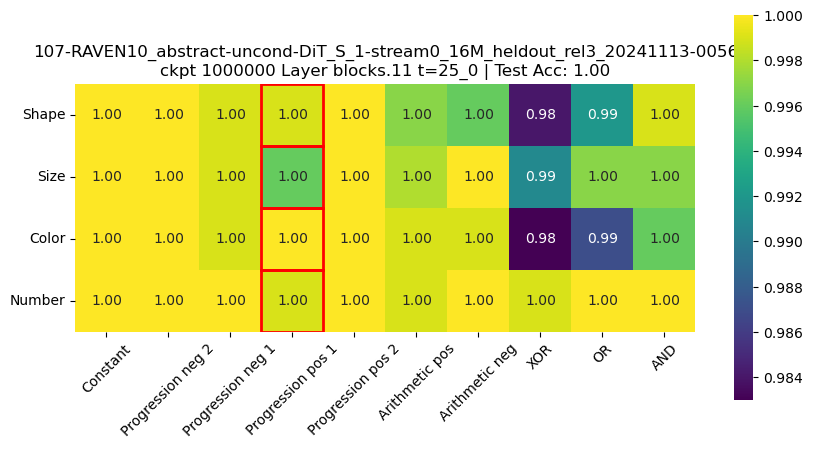

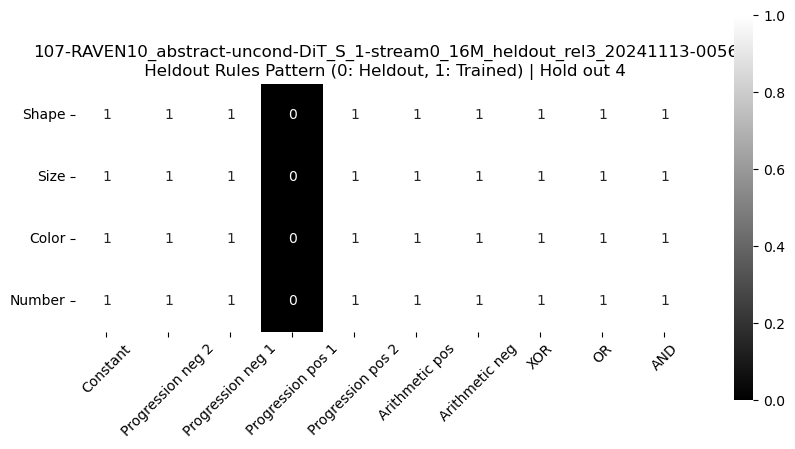

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel3_20241113-0056 t-stat: 0.44, p-val: 6.64e-01


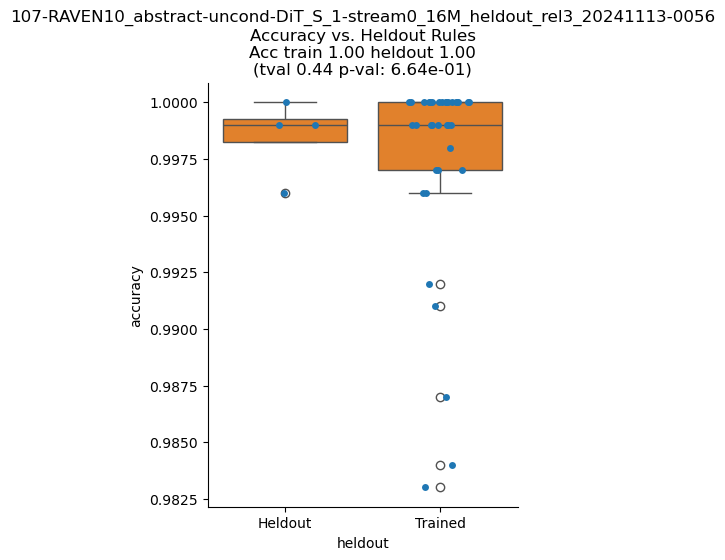

108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel5_20241113-0057          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11       0.995525        0.999992  25.0  1000000  avgtoken


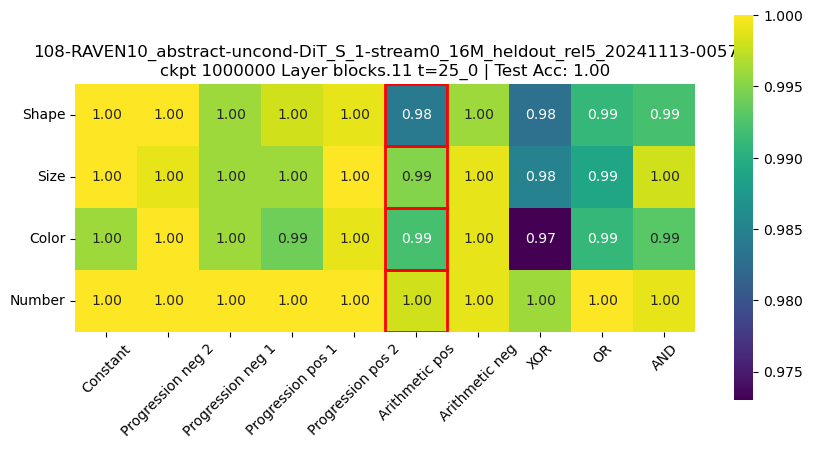

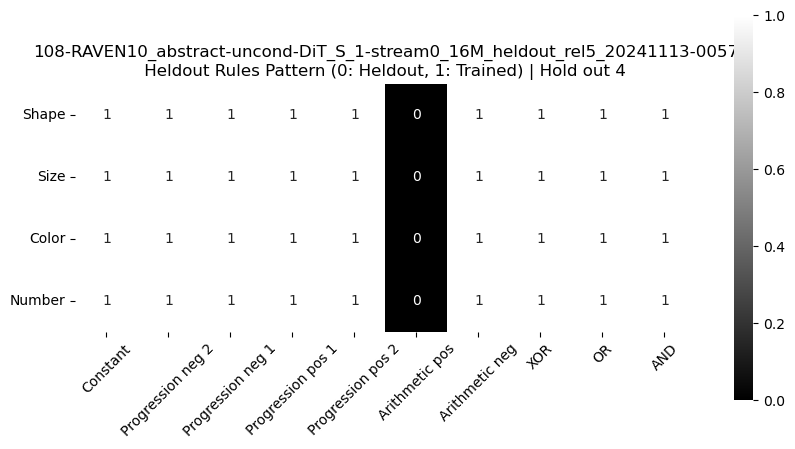

108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel5_20241113-0057 t-stat: -1.18, p-val: 2.46e-01


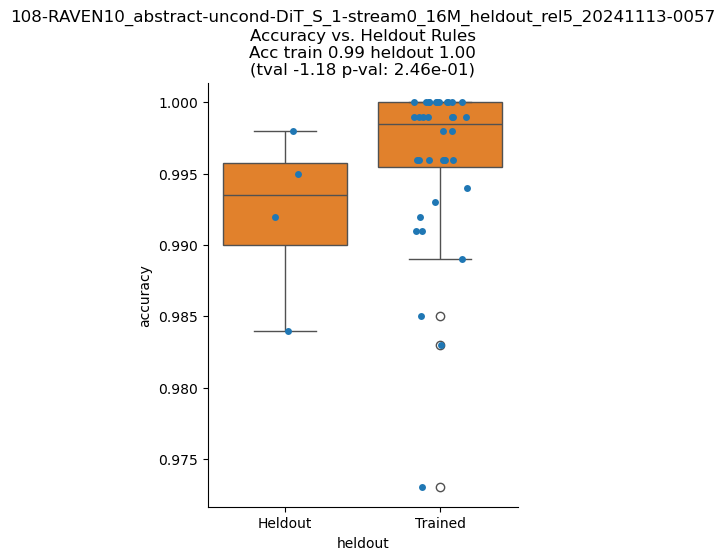

108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9941        0.999317  25.0  1000000  avgtoken


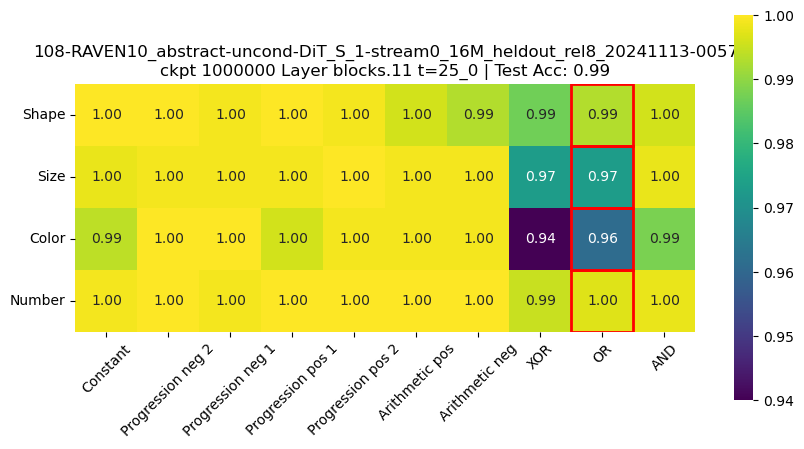

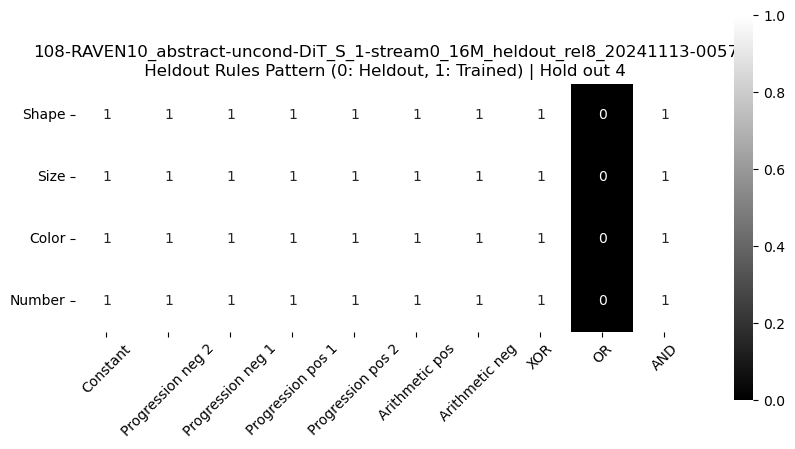

108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057 t-stat: -2.41, p-val: 2.07e-02


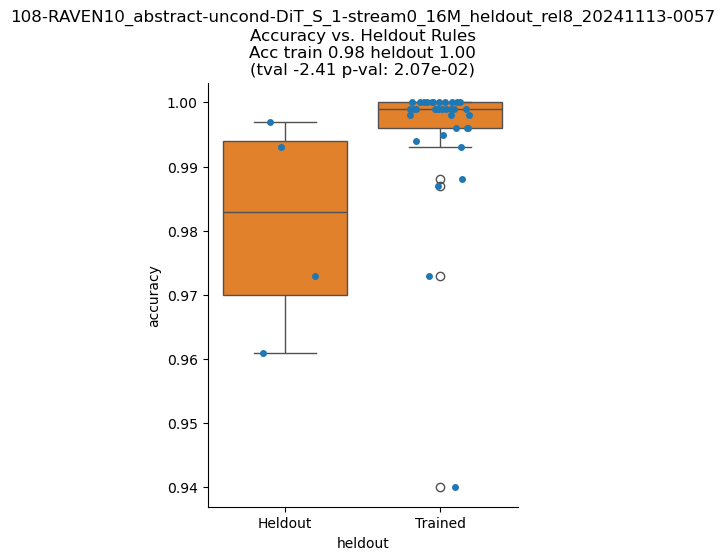

114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel012_20241116-0330          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
179  blocks.11       0.996975             1.0  25.0  1000000  avgtoken


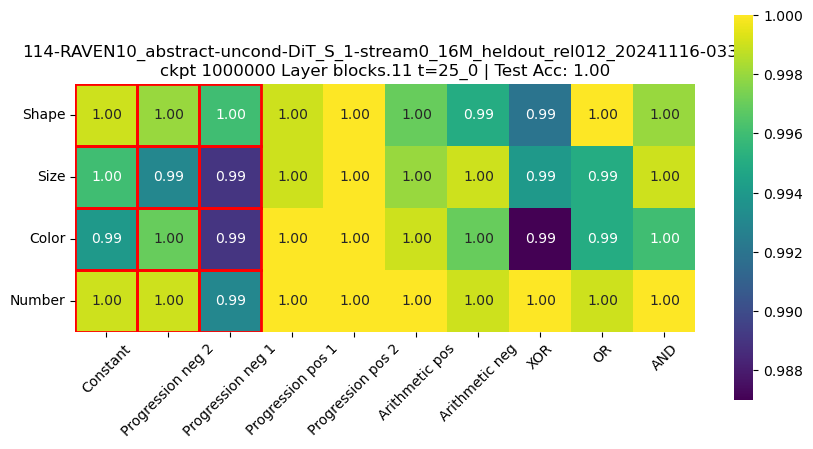

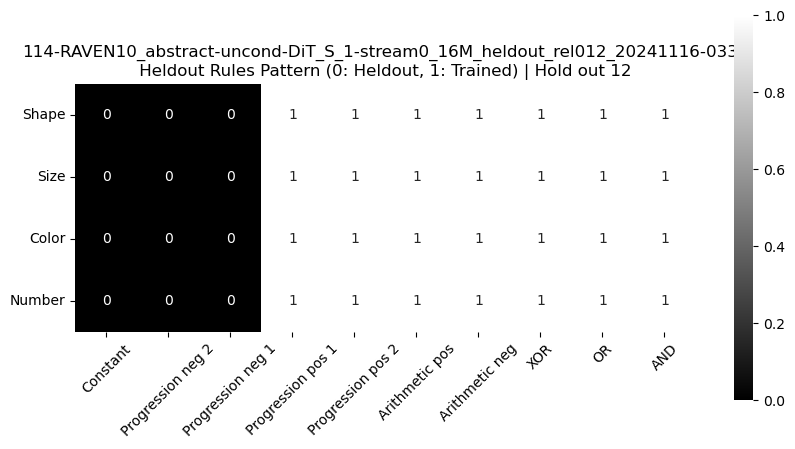

114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel012_20241116-0330 t-stat: -2.32, p-val: 2.57e-02


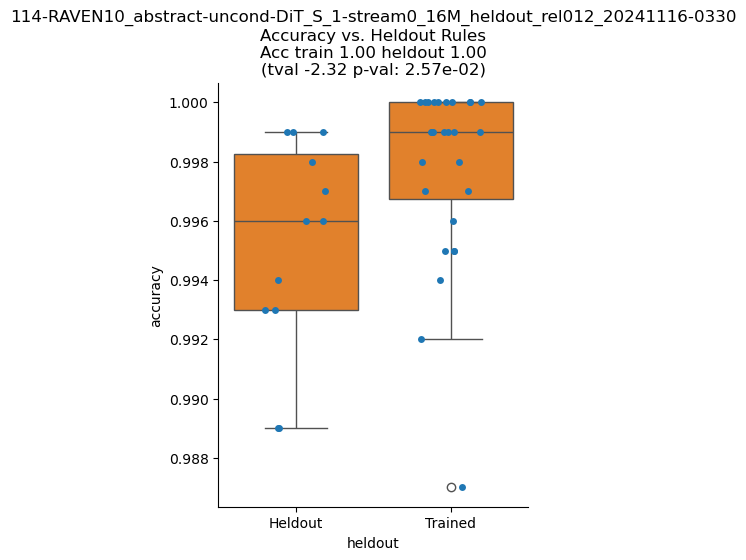

114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel01234_20241116-0330          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
179  blocks.11       0.991175             1.0  25.0  1000000  avgtoken


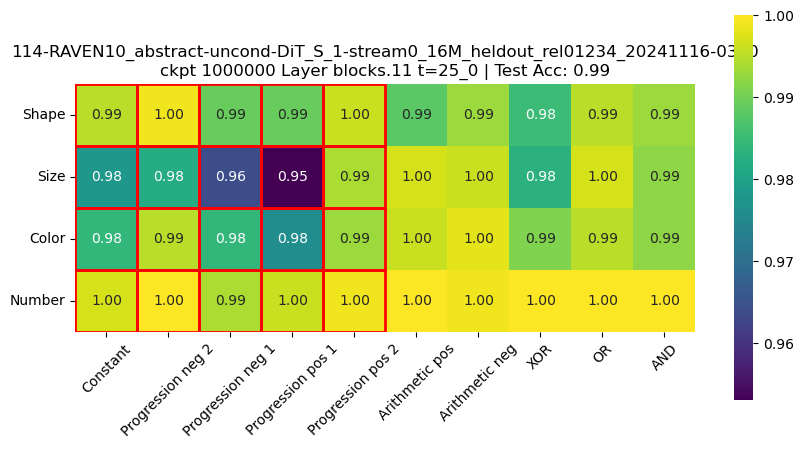

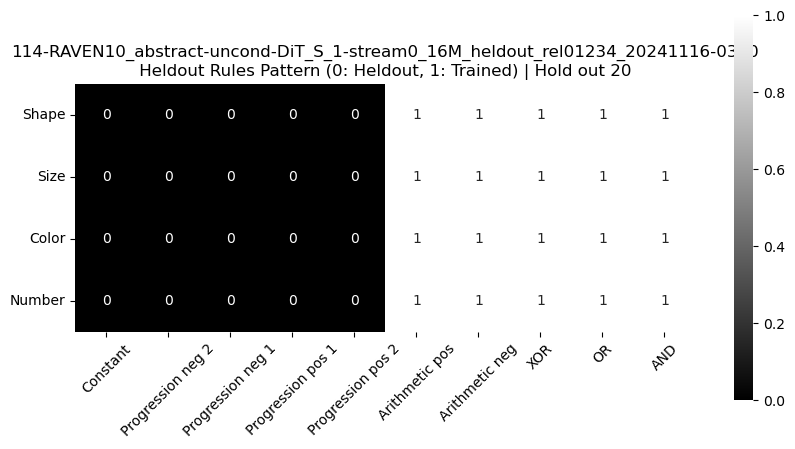

114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel01234_20241116-0330 t-stat: -2.23, p-val: 3.15e-02


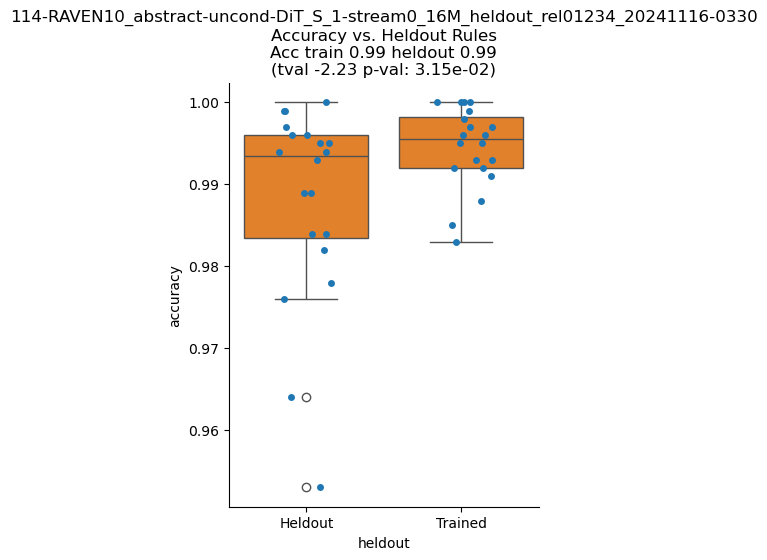

114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel56_20241116-0330          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9923        0.999983  25.0  1000000  avgtoken


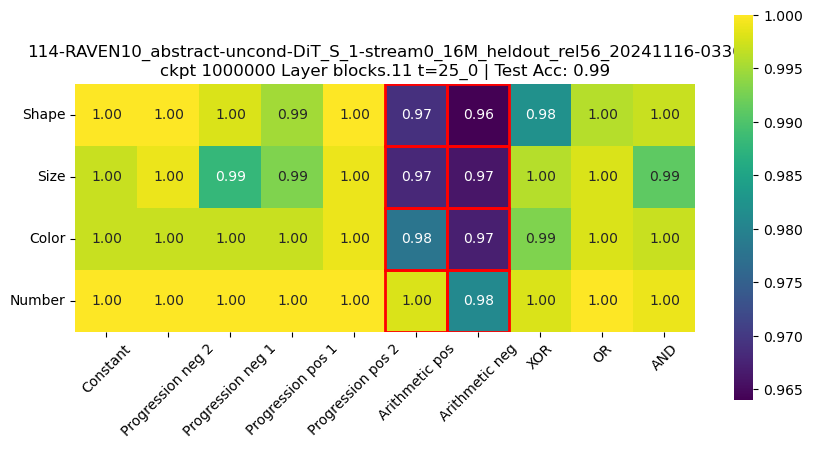

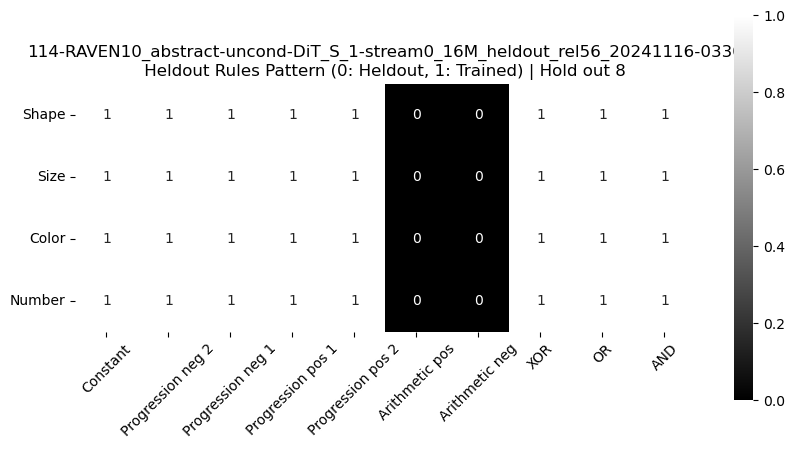

114-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel56_20241116-0330 t-stat: -9.61, p-val: 1.01e-11


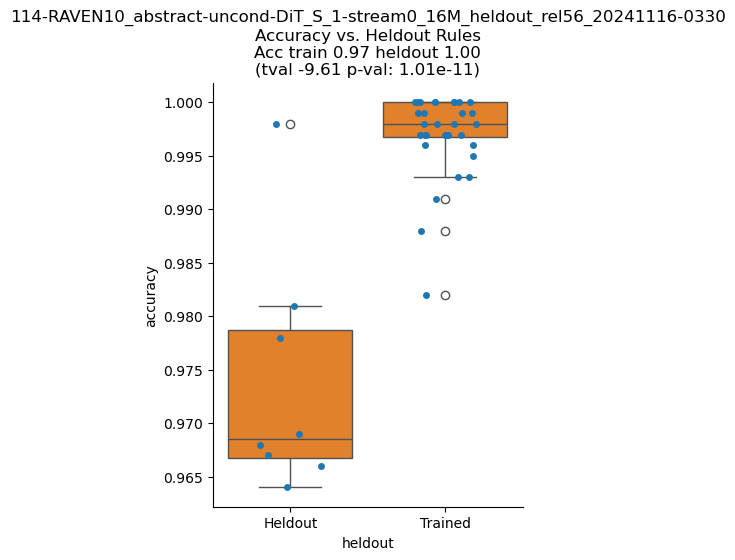

115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel014_20241116-0330          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
179  blocks.11         0.9979             1.0  25.0  1000000  avgtoken


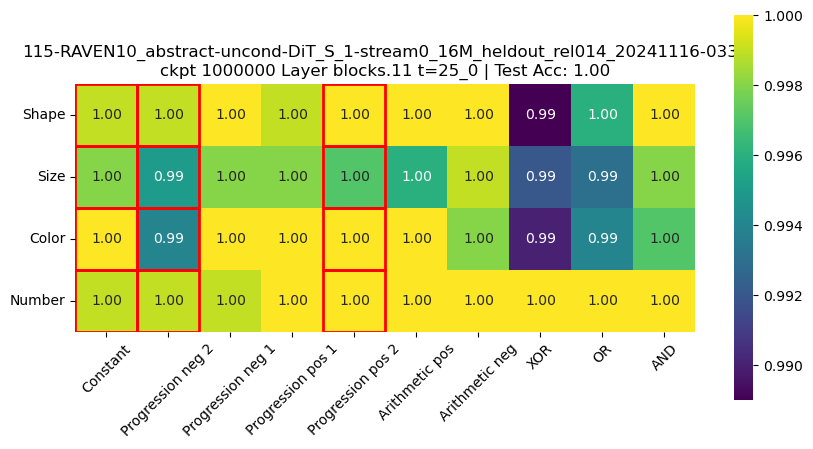

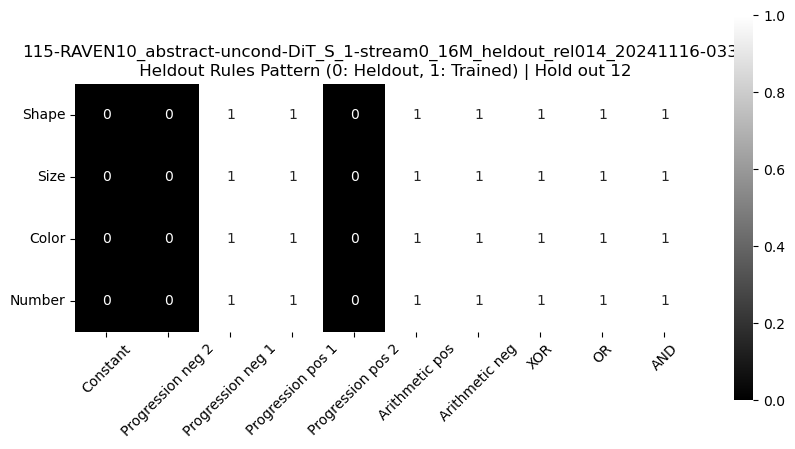

115-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel014_20241116-0330 t-stat: 0.61, p-val: 5.45e-01


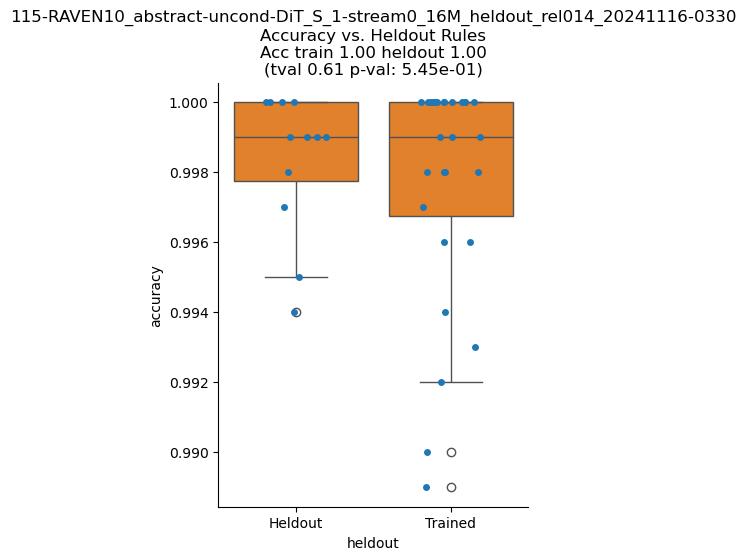

116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel1234_20241116-0331          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
179  blocks.11       0.996625             1.0  25.0  1000000  avgtoken


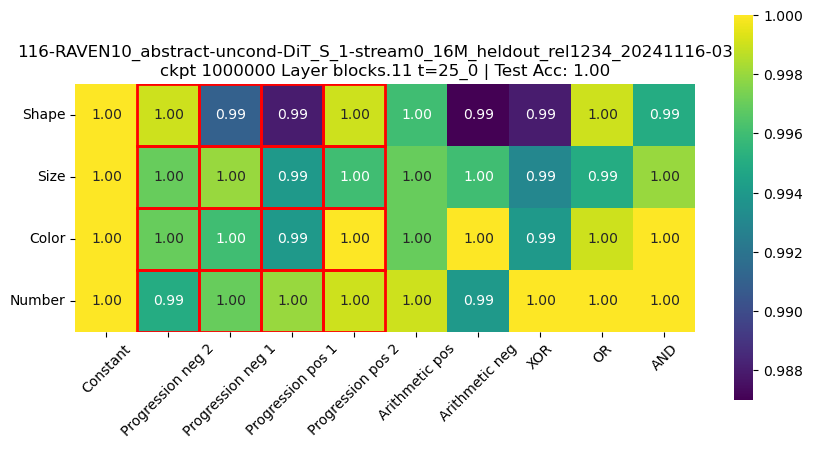

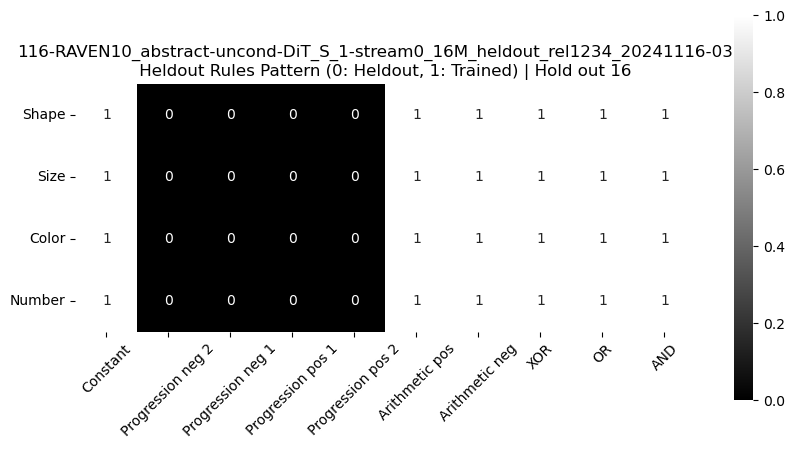

116-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel1234_20241116-0331 t-stat: -0.73, p-val: 4.68e-01


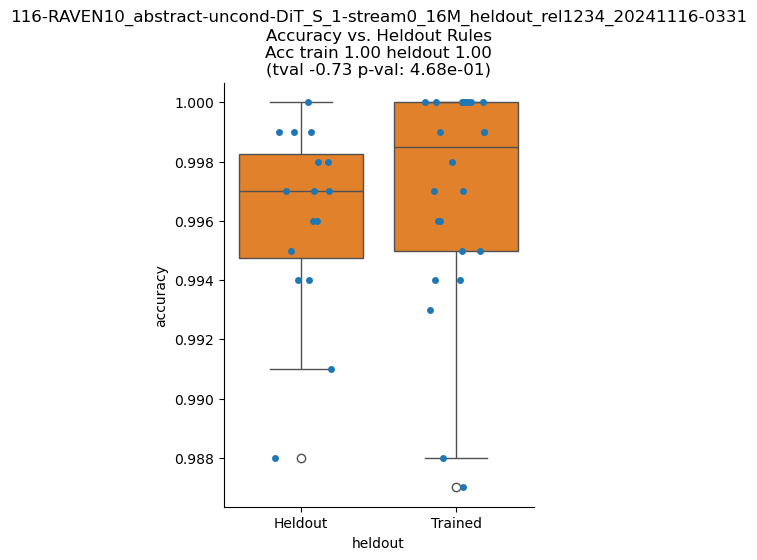

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0123456_20241116-0331          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
179  blocks.11       0.766075        0.807708  25.0  1000000  avgtoken


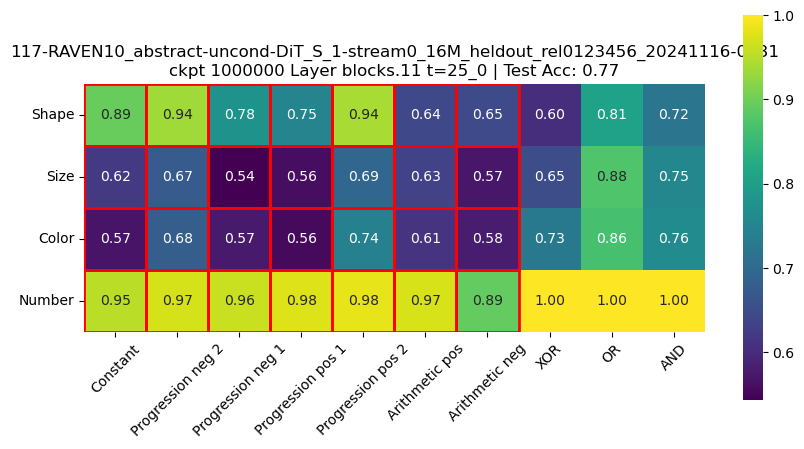

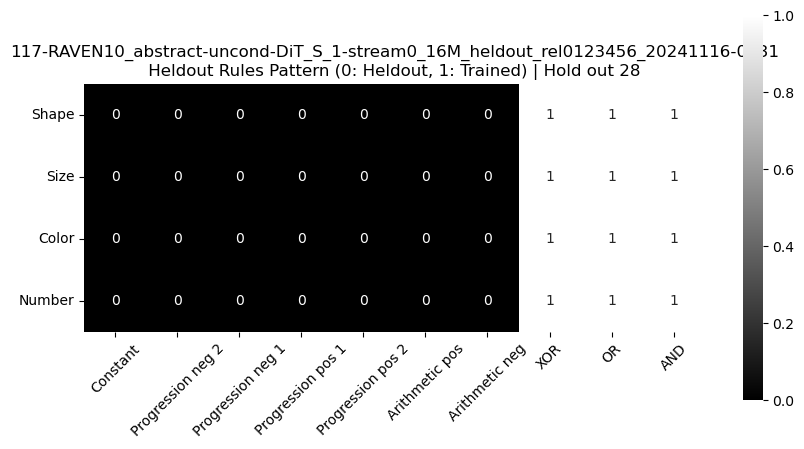

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0123456_20241116-0331 t-stat: -1.26, p-val: 2.17e-01


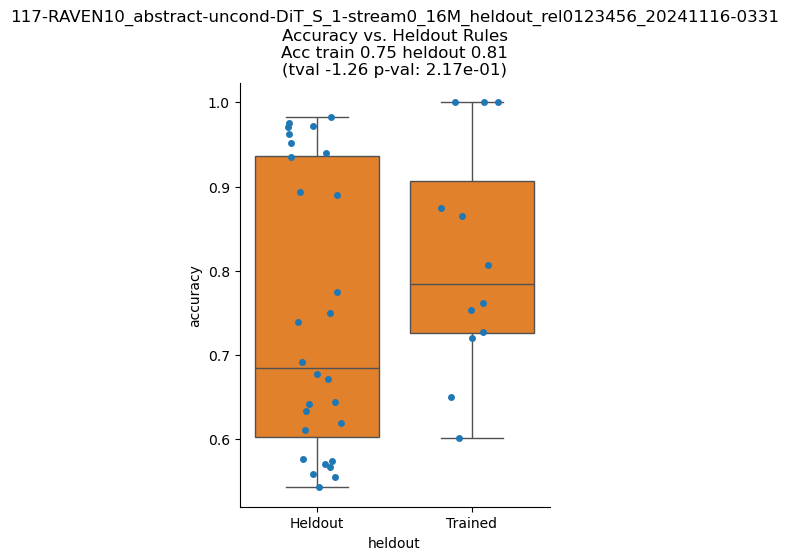

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel023_20241116-0331          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11       0.996125             1.0  25.0  1000000  avgtoken


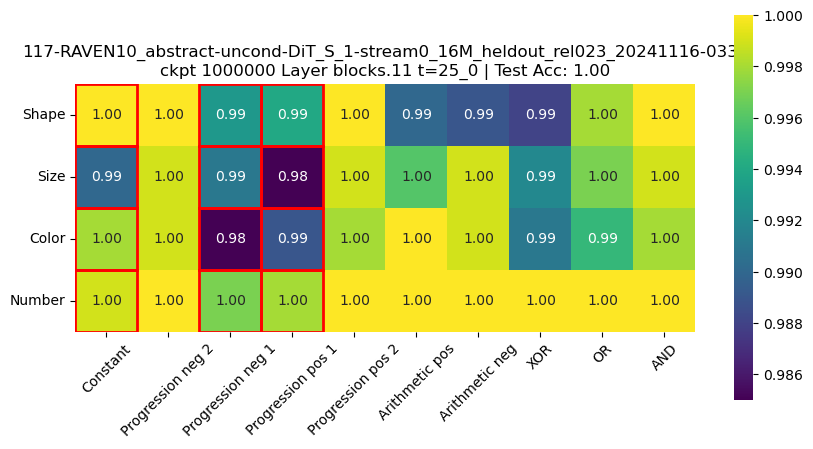

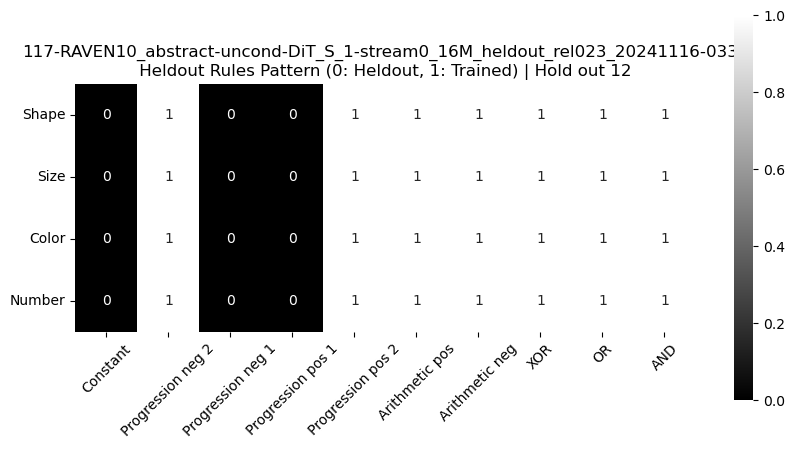

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel023_20241116-0331 t-stat: -2.79, p-val: 8.15e-03


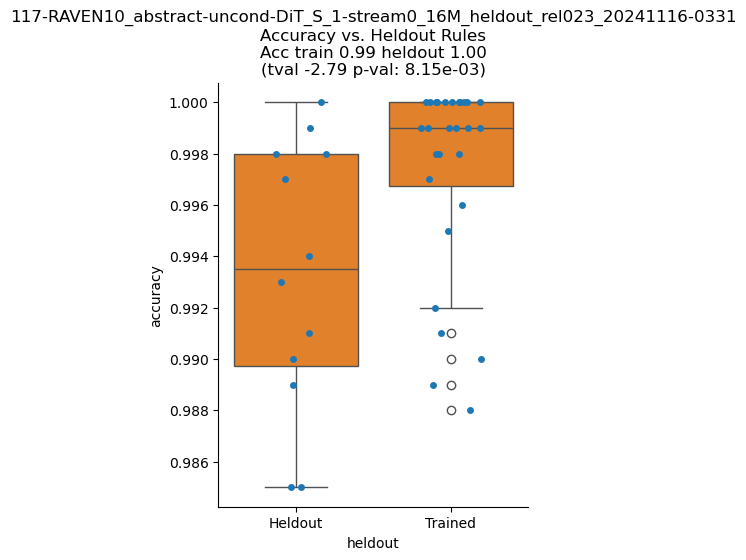

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel034_20241116-0331          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11          0.997             1.0  25.0  1000000  avgtoken


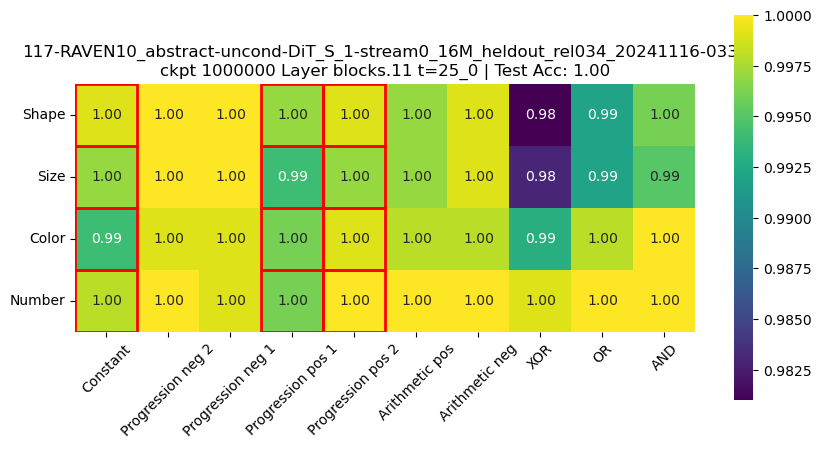

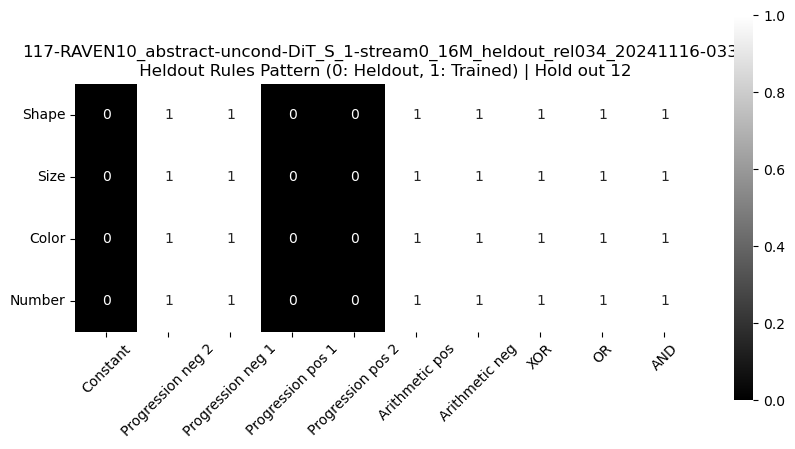

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel034_20241116-0331 t-stat: 0.16, p-val: 8.71e-01


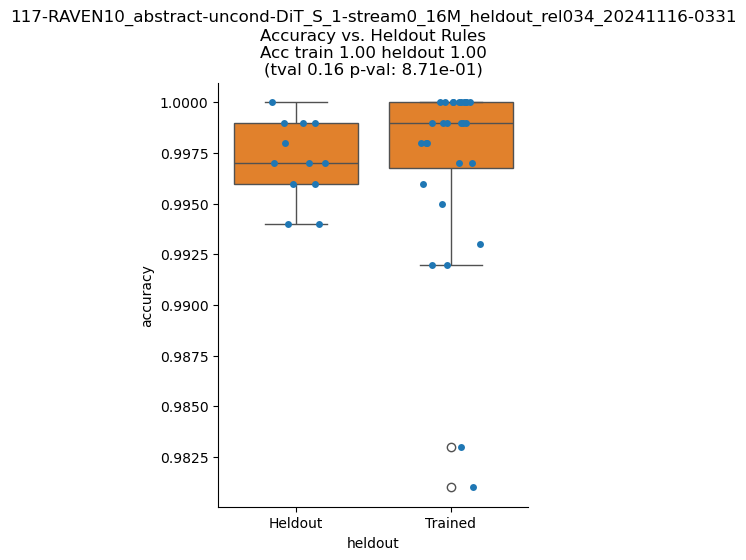

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel123_20241116-0331          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
179  blocks.11       0.997125             1.0  25.0  1000000  avgtoken


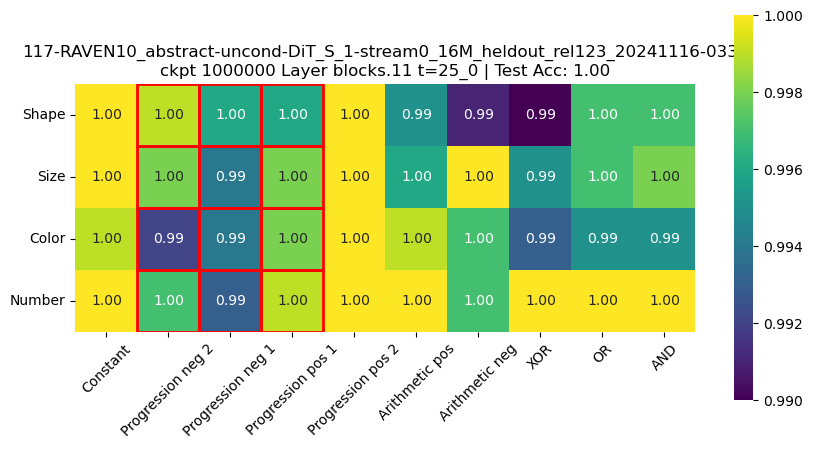

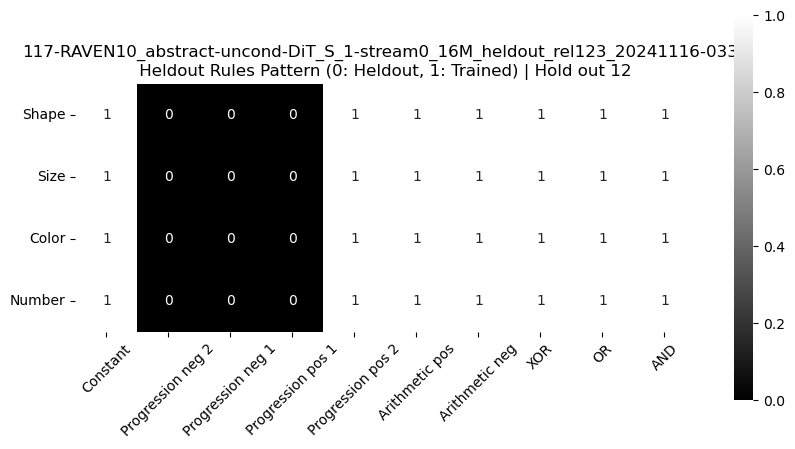

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel123_20241116-0331 t-stat: -1.43, p-val: 1.60e-01


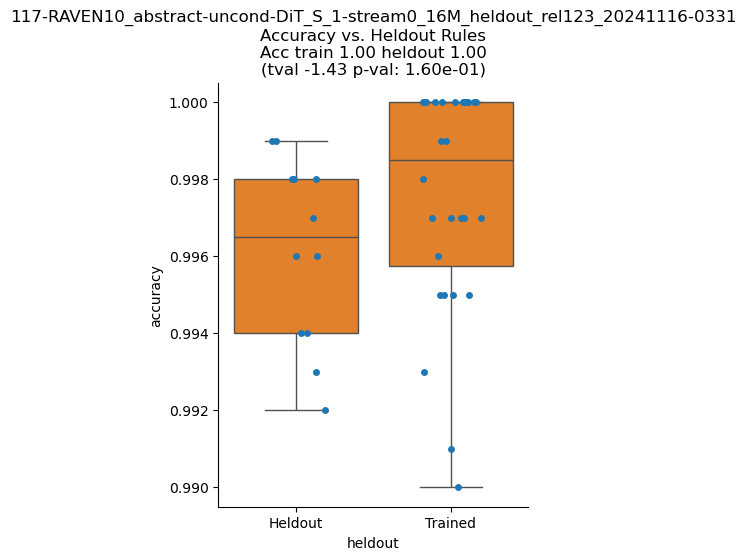

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel789_20241116-0331          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
179  blocks.11         0.9501        0.968275  25.0  1000000  avgtoken


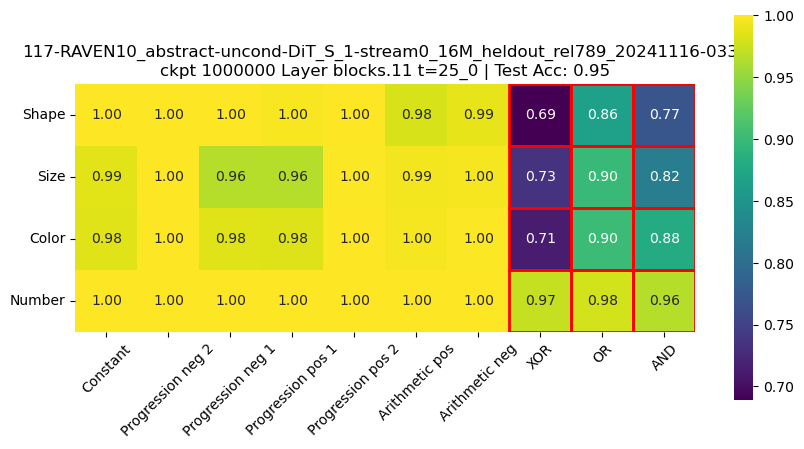

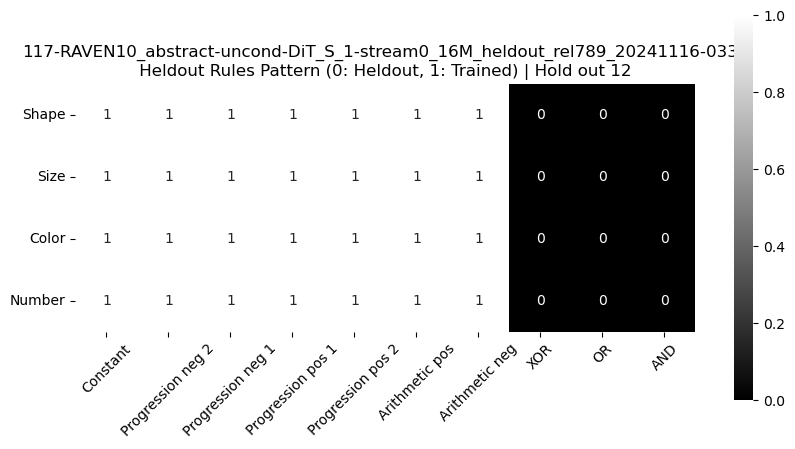

117-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel789_20241116-0331 t-stat: -7.49, p-val: 5.40e-09


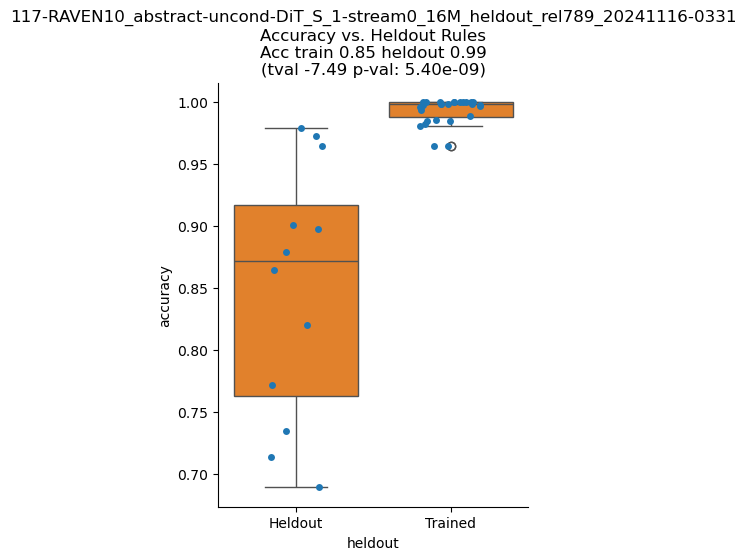

118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel234_20241116-0331          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
189  blocks.11       0.995825             1.0  25.0  1000000  avgtoken


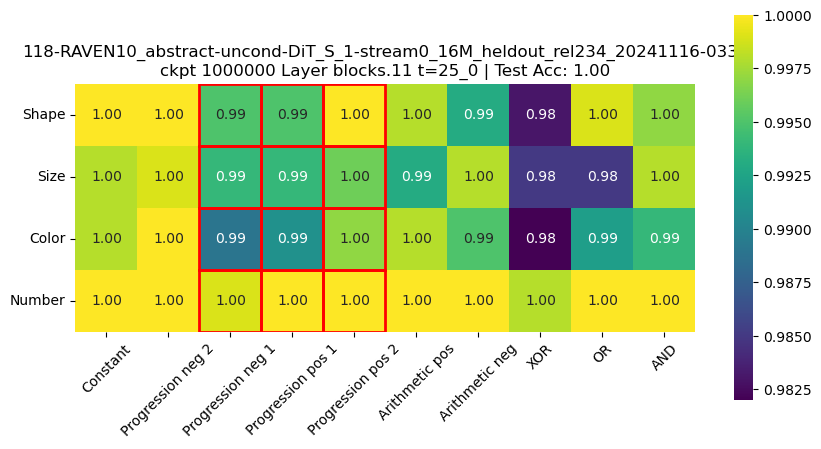

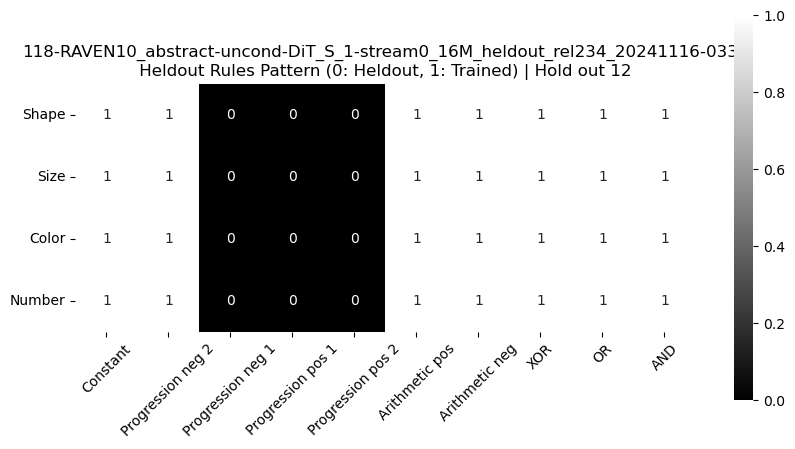

118-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel234_20241116-0331 t-stat: 0.01, p-val: 9.95e-01


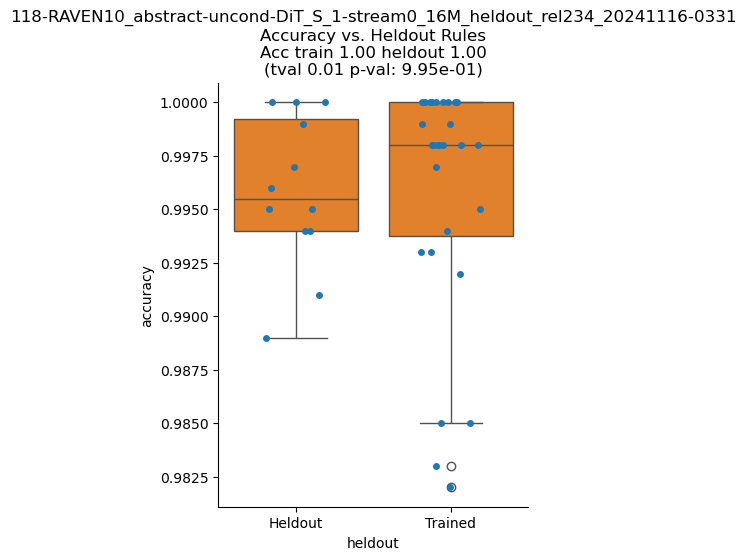

In [18]:
from scipy import stats
syndir = join(figroot, "synopsis")
for expname in expnames:
    expdir = join(exproot, expname)
    figexpdir = join(figroot, expname)
    os.makedirs(figexpdir, exist_ok=True)
    args_path = join(expdir, "args.json")
    assert os.path.exists(args_path), f"Args file not found for {expname}"
    heldout_ids = json.load(open(args_path, "r"))["heldout_ids"]
    repr_dir = join(expdir, "repr_classifier")
    syn_df = pd.read_csv(join(repr_dir, "repr_classifier_synopsis.csv"))
    syn_df_query = syn_df.query("epoch == 1000000 and dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'")
    best_row = syn_df_query.nlargest(1, "Test Accuracy")
    print(expname, best_row)
    test_acc = best_row["Test Accuracy"].item()
    t_str = str(best_row["t"].item()).replace(".", "_")
    dimred_str = best_row["dimred"].item()
    epoch_str = f"{best_row['epoch'].item():07d}"
    layer_str = best_row["Layer"].item()
    # load the results_col for the corresponding setting 
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_{dimred_str}_ckpt{epoch_str}.pkl"), "rb"))
    result_dict_layer = results_col[layer_str]
    pred_cls = result_dict_layer['pred_cls'].cpu()
    cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
    acc_per_rule = np.diag(cm) / cm.sum(axis=1)
    ax1 = plot_rule_heatmap(acc_per_rule.reshape(4,10), heldout_rules=heldout_ids, title=f"{expname}\nckpt {epoch_str} Layer {layer_str} t={t_str} | Test Acc: {test_acc:.2f}")
    saveallforms(figexpdir, f"acc_per_rule_{layer_str}_t{t_str}_ckpt{epoch_str}", )
    saveallforms(syndir, f"acc_per_rule_{expname}_{layer_str}_t{t_str}_ckpt{epoch_str}", )
    plt.show()
    # plot the heldout rules pattern
    rule_vec = np.ones(40) # 40 rules in total
    rule_vec[heldout_ids] = 0 # set the heldout rules to 0
    ax2 = plot_rule_heatmap(rule_vec.reshape(4,10), heldout_rules=[], title=f"{expname}\n Heldout Rules Pattern (0: Heldout, 1: Trained) | Hold out {len(set(heldout_ids))} ", fmt=".0f", cmap="gray")
    saveallforms(figexpdir, f"heldout_rules_pattern", )
    saveallforms(syndir, f"heldout_rules_pattern_{expname}", )
    plt.show()
    
    # plot the scatter plot of accuracy vs. heldout rules, trained vs heldout
    df = pd.DataFrame({"accuracy": acc_per_rule, "heldout": rule_vec})
    fig, ax = plt.subplots(1,1,figsize=(4, 5.5))
    sns.stripplot(x="heldout", y="accuracy", data=df, ax=ax, jitter=0.2, dodge=True)
    sns.boxplot(x="heldout", y="accuracy", data=df, ax=ax)
    # perform t test
    t_stat, p_val = stats.ttest_ind(df[df["heldout"] == 0]["accuracy"], df[df["heldout"] == 1]["accuracy"])
    print(f"{expname} t-stat: {t_stat:.2f}, p-val: {p_val:.2e}")
    # set ticks 0, 1
    test_acc_train = df[df['heldout'] == 0]['accuracy'].mean()
    test_acc_heldout = df[df['heldout'] == 1]['accuracy'].mean()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Heldout", "Trained"])
    ax.set_title(f"{expname}\nAccuracy vs. Heldout Rules\nAcc train {test_acc_train:.2f} heldout {test_acc_heldout:.2f}\n(tval {t_stat:.2f} p-val: {p_val:.2e})")
    saveallforms(figexpdir, f"train_vs_heldout_cmp_{layer_str}_t{t_str}_ckpt{epoch_str}", )
    saveallforms(syndir, f"train_vs_heldout_cmp_{expname}_{layer_str}_t{t_str}_ckpt{epoch_str}", )
    plt.show()
    # break 
#     heldout_profiles[expname] = heldout_ids
# for expname, heldout_ids in heldout_profiles.items():
#     print(expname, '\t heldout #', len(set(heldout_ids)), set(heldout_ids))

In [31]:
acc_per_rule

array([0.912, 0.978, 0.962, 0.841, 0.97 , 0.764, 0.925, 0.588, 0.744,
       0.779, 0.901, 0.969, 0.891, 0.938, 0.926, 0.906, 0.806, 0.634,
       0.88 , 0.704, 0.882, 0.872, 0.936, 0.927, 0.916, 0.907, 0.767,
       0.657, 0.866, 0.711, 0.99 , 0.985, 0.999, 0.982, 0.979, 0.987,
       0.983, 0.934, 0.966, 0.948])

In [25]:
result_dict_layer.pred_cls.shape

torch.Size([40000])

### Scratch

In [ ]:
from rule_new_utils import attribute_dict, relation_dict
from sklearn.metrics import confusion_matrix
def visualize_cm(cm, heldout_rules, titlestr=""):
    figh1 = plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    add_rectangles(heldout_rules)
    plt.xticks(np.arange(10)+0.5, [relation_dict[i] for i in range(10)], rotation=45)
    plt.yticks(np.arange(4)+0.5, [attribute_dict[i] for i in range(4)], rotation=0)
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh2, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()
    return figh1, figh2
    
    
def visualize_cm_default(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(1,-1) / cm.sum(axis=1)[None,] * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    # for rule_id in heldout_rules:
    #     row = rule_id // 10
    #     col = rule_id % 10
    #     plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     if int(label.get_text()) in heldout_rules:
    #         label.set_color('red')
    plt.show()

* Show the pattern of held out rules
* Show the pattern of accuracy split by rules

In [ ]:

for t_scalar in [25.0]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt1000000EMA.pkl"), "rb"))
    for layer in results_col.keys():
        pred_cls = results_col[layer]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        fig1, fig2 = visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"{expname}\nckpt 1000000EMA Layer {layer} t={t_scalar}")